#Introduction

After we tried to extract seasonality, ee used KFold cross validation.

Previously we tried with fewer folds, with interesting results.

Now we try with 15 folds

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=6640b5ba7167828f4c50cc3acf6e430c61f142b1d7ce12344a10a958b12aa713
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'v2_KfoldSeasonality' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
dataset['date'] = pd.date_range(start='1/1/1979', periods=len(dataset), freq='D')
# Convert your daily column from just string to DateTime (skip if already done)
dataset['date'] = pd.to_datetime(dataset['date'])
# Set the column 'Date' as index (skip if already done)
dataset = dataset.set_index('date')
# Specify datetime frequency
dataset = dataset.asfreq('D')
dataset2 = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
date,,,,,,,
1979-01-01,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1979-01-02,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
1979-01-03,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
1979-01-04,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
1979-01-05,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68528 entries, 1979-01-01 to 2166-08-15
Freq: D
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 4.2 MB


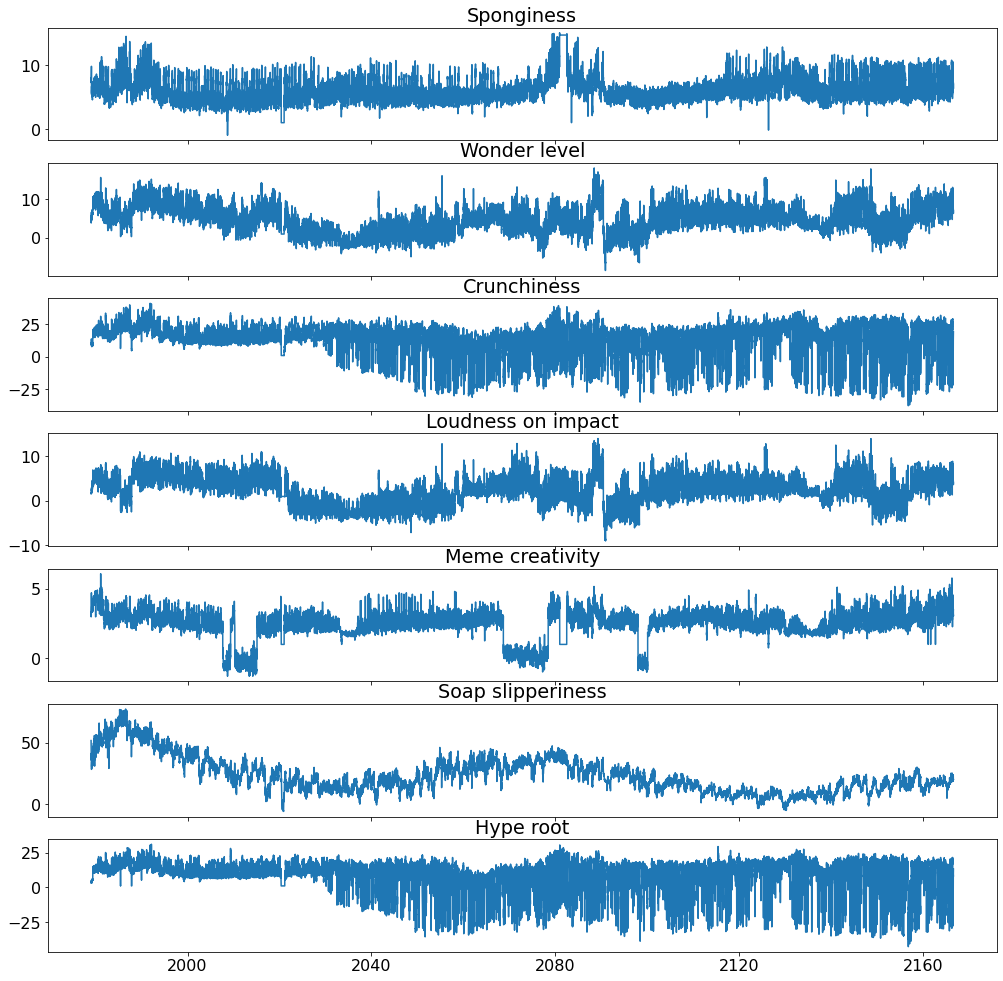

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)


(68528, 7)


In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
# Decompose in trend + seasonality + residual

from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(X_train_raw, model="additive", extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

# Plot decomposed time series

In [ ]:
# We consider only seasonality and trend

X_train_raw = seasonal+trend

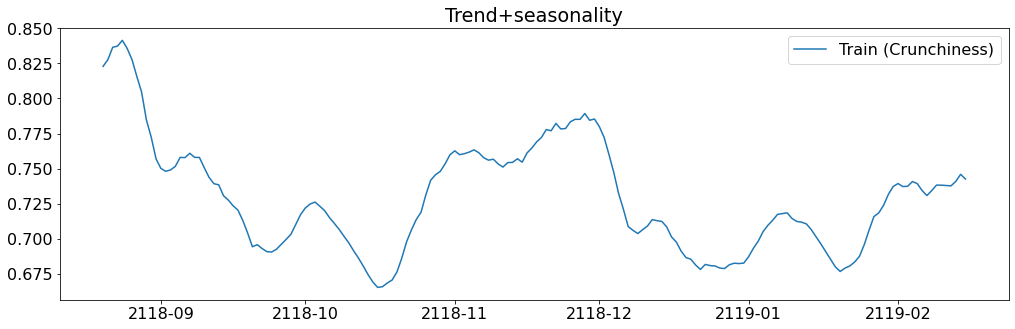

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Trend+seasonality')
plt.legend()
plt.show()

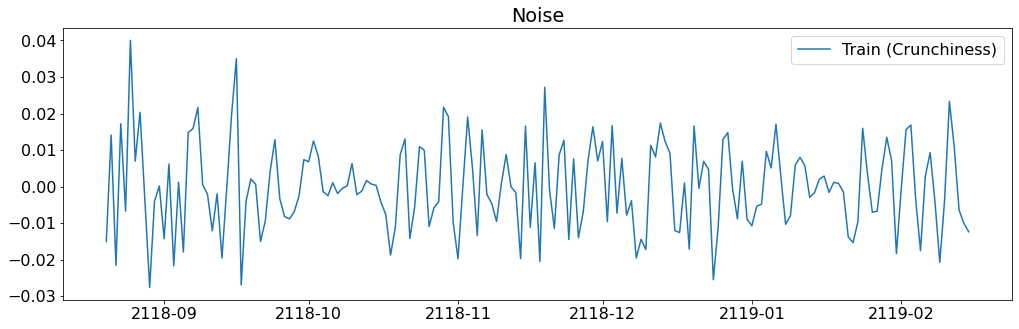

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(residual.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Noise')
plt.legend()
plt.show()

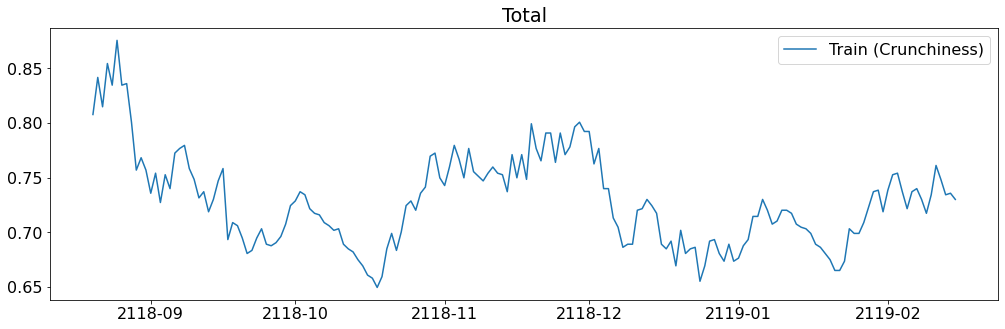

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(residual.Crunchiness[51000:51180]+X_train_raw.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Total')
plt.legend()
plt.show()

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=15, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    print(lstm.shape)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=0.0005), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape

((13526, 90, 7), (13526, 864, 7))

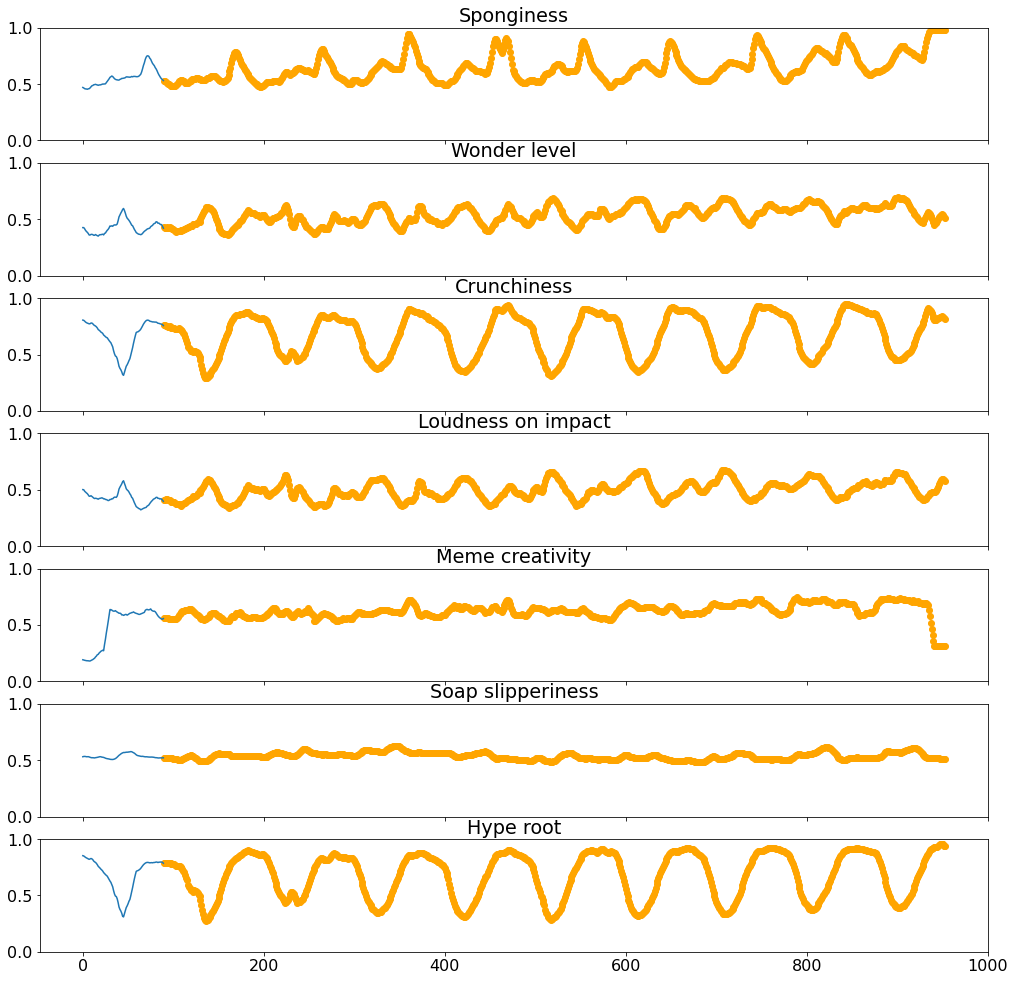

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

num_folds = 15 # number of folds for K-fold

# we will have num_folds models
models = []

# needed to save scores
val_rmses = []

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 7)


In [ ]:
kfold = KFold(n_splits=num_folds) #can be set a shuffle parameter (see documentation)

#Kfold

In [ ]:
fold_no = 0
for train, test in kfold.split(X_train, y_train):

  # Define the model architecture
  model = build_LSTM_model(input_shape, output_shape)
  # model.summary()  # commented to avoid too much prints
  # tfk.utils.plot_model(model, expand_nested=True) # commented to avoid too much prints

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  # Create folders and callbacks and fit
  # Fit data to model
  cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

  # restore checkpoints:
  # model.load_weights('/gdrive/MyDrive/Documenti/Università/Magistrale/SecondoAnno/PrimoSemestre/AN2DL/Challenge2/Check/+'title'+_datetime/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
  # In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

  # Train the model
  history = model.fit(
    x = X_train[train],
    y = y_train[train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
  ).history

  # appending generated model
  models.append(model)

  # Saving generated model. Useful to be done here, otherwise, if colab stops you, you loose already generated ones
  model.save('Models/'+title+'_fold_nmbr_'+str(fold_no))

  # Storing metrics:
  scores = model.evaluate(X_train[test], y_train[test]) # evaluate on the selected fold
  print(scores)
  val_rmses.append(scores[2])

  # Increase fold number
  fold_no = fold_no + 1

(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0635 - mae: 0.1618 - rmse: 0.2520

1421/1421 [==============================] - 37s 22ms/step - loss: 0.0635 - mae: 0.1618 - rmse: 0.2520 - val_loss: 0.0349 - val_mae: 0.1195 - val_rmse: 0.1868 - lr: 5.0000e-04
Epoch 2/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0246 - mae: 0.0941 - rmse: 0.1569

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0246 - mae: 0.0941 - rmse: 0.1569 - val_loss: 0.0222 - val_mae: 0.0948 - val_rmse: 0.1490 - lr: 5.0000e-04
Epoch 3/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0803 - rmse: 0.1316

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0173 - mae: 0.0803 - rmse: 0.1316 - val_loss: 0.0178 - val_mae: 0.0883 - val_rmse: 0.1334 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0731 - rmse: 0.1171

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0137 - mae: 0.0731 - rmse: 0.1171 - val_loss: 0.0151 - val_mae: 0.0830 - val_rmse: 0.1228 - lr: 5.0000e-04
Epoch 5/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0683 - rmse: 0.1073

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0115 - mae: 0.0683 - rmse: 0.1073 - val_loss: 0.0135 - val_mae: 0.0796 - val_rmse: 0.1162 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0649 - rmse: 0.0990

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0098 - mae: 0.0649 - rmse: 0.0990 - val_loss: 0.0124 - val_mae: 0.0791 - val_rmse: 0.1113 - lr: 5.0000e-04
Epoch 7/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0087 - mae: 0.0623 - rmse: 0.0931

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0087 - mae: 0.0623 - rmse: 0.0931 - val_loss: 0.0118 - val_mae: 0.0768 - val_rmse: 0.1085 - lr: 5.0000e-04
Epoch 8/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0608 - rmse: 0.0901

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0081 - mae: 0.0608 - rmse: 0.0901 - val_loss: 0.0118 - val_mae: 0.0773 - val_rmse: 0.1087 - lr: 5.0000e-04
Epoch 9/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0594 - rmse: 0.0873

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0076 - mae: 0.0594 - rmse: 0.0873 - val_loss: 0.0107 - val_mae: 0.0747 - val_rmse: 0.1036 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0582 - rmse: 0.0851

1421/1421 [==============================] - 29s 21ms/step - loss: 0.0072 - mae: 0.0582 - rmse: 0.0851 - val_loss: 0.0105 - val_mae: 0.0730 - val_rmse: 0.1022 - lr: 5.0000e-04
Epoch 11/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0573 - rmse: 0.0833

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0069 - mae: 0.0573 - rmse: 0.0833 - val_loss: 0.0106 - val_mae: 0.0748 - val_rmse: 0.1027 - lr: 5.0000e-04
Epoch 12/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0562 - rmse: 0.0814

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0066 - mae: 0.0562 - rmse: 0.0814 - val_loss: 0.0105 - val_mae: 0.0740 - val_rmse: 0.1023 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0556 - rmse: 0.0802

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0064 - mae: 0.0556 - rmse: 0.0802 - val_loss: 0.0103 - val_mae: 0.0741 - val_rmse: 0.1013 - lr: 5.0000e-04
Epoch 14/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0546 - rmse: 0.0780

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0061 - mae: 0.0546 - rmse: 0.0780 - val_loss: 0.0099 - val_mae: 0.0730 - val_rmse: 0.0995 - lr: 5.0000e-04
Epoch 15/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0540 - rmse: 0.0768

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0059 - mae: 0.0540 - rmse: 0.0768 - val_loss: 0.0101 - val_mae: 0.0744 - val_rmse: 0.1006 - lr: 5.0000e-04
Epoch 16/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.0534 - rmse: 0.0754

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0057 - mae: 0.0534 - rmse: 0.0754 - val_loss: 0.0102 - val_mae: 0.0741 - val_rmse: 0.1011 - lr: 5.0000e-04
Epoch 17/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0527 - rmse: 0.0744

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0055 - mae: 0.0527 - rmse: 0.0744 - val_loss: 0.0098 - val_mae: 0.0727 - val_rmse: 0.0991 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0523 - rmse: 0.0738

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0055 - mae: 0.0523 - rmse: 0.0739 - val_loss: 0.0100 - val_mae: 0.0734 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 19/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0520 - rmse: 0.0733

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0054 - mae: 0.0520 - rmse: 0.0733 - val_loss: 0.0097 - val_mae: 0.0723 - val_rmse: 0.0987 - lr: 5.0000e-04
Epoch 20/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0724

1421/1421 [==============================] - 29s 21ms/step - loss: 0.0052 - mae: 0.0513 - rmse: 0.0724 - val_loss: 0.0106 - val_mae: 0.0757 - val_rmse: 0.1030 - lr: 5.0000e-04
Epoch 21/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0512 - rmse: 0.0723

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0052 - mae: 0.0512 - rmse: 0.0723 - val_loss: 0.0105 - val_mae: 0.0752 - val_rmse: 0.1023 - lr: 5.0000e-04
Epoch 22/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0504 - rmse: 0.0711

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0051 - mae: 0.0504 - rmse: 0.0711 - val_loss: 0.0102 - val_mae: 0.0740 - val_rmse: 0.1008 - lr: 5.0000e-04
Epoch 23/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0503 - rmse: 0.0707

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0503 - rmse: 0.0707 - val_loss: 0.0100 - val_mae: 0.0724 - val_rmse: 0.0998 - lr: 5.0000e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0501 - rmse: 0.0707

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0501 - rmse: 0.0707 - val_loss: 0.0099 - val_mae: 0.0728 - val_rmse: 0.0995 - lr: 5.0000e-04
Epoch 25/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0665

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0665 - val_loss: 0.0105 - val_mae: 0.0749 - val_rmse: 0.1026 - lr: 2.5000e-04
Epoch 26/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0470 - rmse: 0.0661

1421/1421 [==============================] - 29s 21ms/step - loss: 0.0044 - mae: 0.0470 - rmse: 0.0661 - val_loss: 0.0104 - val_mae: 0.0740 - val_rmse: 0.1018 - lr: 2.5000e-04
Epoch 27/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0467 - rmse: 0.0657

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0043 - mae: 0.0467 - rmse: 0.0657 - val_loss: 0.0102 - val_mae: 0.0734 - val_rmse: 0.1011 - lr: 2.5000e-04
Epoch 28/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0463 - rmse: 0.0650

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0042 - mae: 0.0463 - rmse: 0.0650 - val_loss: 0.0099 - val_mae: 0.0724 - val_rmse: 0.0995 - lr: 2.5000e-04
Epoch 29/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0649

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0042 - mae: 0.0462 - rmse: 0.0649 - val_loss: 0.0106 - val_mae: 0.0750 - val_rmse: 0.1031 - lr: 2.5000e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0448 - rmse: 0.0629

1421/1421 [==============================] - 29s 21ms/step - loss: 0.0040 - mae: 0.0448 - rmse: 0.0629 - val_loss: 0.0108 - val_mae: 0.0757 - val_rmse: 0.1041 - lr: 1.2500e-04
Epoch 31/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0627

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0627 - val_loss: 0.0105 - val_mae: 0.0744 - val_rmse: 0.1024 - lr: 1.2500e-04
Epoch 32/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0444 - rmse: 0.0623

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0039 - mae: 0.0444 - rmse: 0.0623 - val_loss: 0.0103 - val_mae: 0.0739 - val_rmse: 0.1014 - lr: 1.2500e-04
Epoch 33/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0444 - rmse: 0.0623

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0039 - mae: 0.0444 - rmse: 0.0623 - val_loss: 0.0110 - val_mae: 0.0761 - val_rmse: 0.1049 - lr: 1.2500e-04
Epoch 34/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0441 - rmse: 0.0618

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0441 - rmse: 0.0618 - val_loss: 0.0109 - val_mae: 0.0762 - val_rmse: 0.1046 - lr: 1.2500e-04


29/29 [==============================] - 0s 8ms/step - loss: 0.0169 - mae: 0.0974 - rmse: 0.1301
[0.01693551614880562, 0.09743141382932663, 0.13013653457164764]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0649 - mae: 0.1635 - rmse: 0.2547

1421/1421 [==============================] - 33s 21ms/step - loss: 0.0648 - mae: 0.1634 - rmse: 0.2546 - val_loss: 0.0383 - val_mae: 0.1243 - val_rmse: 0.1958 - lr: 5.0000e-04
Epoch 2/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0272 - mae: 0.0985 - rmse: 0.1649

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0272 - mae: 0.0985 - rmse: 0.1649 - val_loss: 0.0240 - val_mae: 0.0976 - val_rmse: 0.1548 - lr: 5.0000e-04
Epoch 3/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0184 - mae: 0.0828 - rmse: 0.1356

1421/1421 [==============================] - 29s 21ms/step - loss: 0.0184 - mae: 0.0828 - rmse: 0.1356 - val_loss: 0.0185 - val_mae: 0.0909 - val_rmse: 0.1360 - lr: 5.0000e-04
Epoch 4/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0136 - mae: 0.0740 - rmse: 0.1166

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0136 - mae: 0.0740 - rmse: 0.1166 - val_loss: 0.0142 - val_mae: 0.0812 - val_rmse: 0.1191 - lr: 5.0000e-04
Epoch 5/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0110 - mae: 0.0687 - rmse: 0.1050

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0110 - mae: 0.0687 - rmse: 0.1050 - val_loss: 0.0130 - val_mae: 0.0788 - val_rmse: 0.1142 - lr: 5.0000e-04
Epoch 6/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0657 - rmse: 0.0988

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0098 - mae: 0.0657 - rmse: 0.0988 - val_loss: 0.0125 - val_mae: 0.0799 - val_rmse: 0.1117 - lr: 5.0000e-04
Epoch 7/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0634 - rmse: 0.0945

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0089 - mae: 0.0634 - rmse: 0.0945 - val_loss: 0.0115 - val_mae: 0.0746 - val_rmse: 0.1075 - lr: 5.0000e-04
Epoch 8/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0083 - mae: 0.0618 - rmse: 0.0913

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0083 - mae: 0.0618 - rmse: 0.0913 - val_loss: 0.0110 - val_mae: 0.0740 - val_rmse: 0.1048 - lr: 5.0000e-04
Epoch 9/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0604 - rmse: 0.0884

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0078 - mae: 0.0604 - rmse: 0.0884 - val_loss: 0.0107 - val_mae: 0.0739 - val_rmse: 0.1034 - lr: 5.0000e-04
Epoch 10/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0592 - rmse: 0.0866

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0075 - mae: 0.0592 - rmse: 0.0866 - val_loss: 0.0105 - val_mae: 0.0722 - val_rmse: 0.1023 - lr: 5.0000e-04
Epoch 11/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0583 - rmse: 0.0850

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0072 - mae: 0.0583 - rmse: 0.0850 - val_loss: 0.0104 - val_mae: 0.0727 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 12/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0570 - rmse: 0.0818

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0067 - mae: 0.0570 - rmse: 0.0818 - val_loss: 0.0120 - val_mae: 0.0811 - val_rmse: 0.1094 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0569 - rmse: 0.0814

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0066 - mae: 0.0569 - rmse: 0.0813 - val_loss: 0.0101 - val_mae: 0.0722 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 14/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0552 - rmse: 0.0787

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0062 - mae: 0.0552 - rmse: 0.0787 - val_loss: 0.0097 - val_mae: 0.0705 - val_rmse: 0.0987 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0544 - rmse: 0.0774

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0060 - mae: 0.0544 - rmse: 0.0774 - val_loss: 0.0097 - val_mae: 0.0715 - val_rmse: 0.0983 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0539 - rmse: 0.0764

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0058 - mae: 0.0539 - rmse: 0.0764 - val_loss: 0.0103 - val_mae: 0.0732 - val_rmse: 0.1017 - lr: 5.0000e-04
Epoch 17/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0531 - rmse: 0.0754

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0057 - mae: 0.0531 - rmse: 0.0754 - val_loss: 0.0098 - val_mae: 0.0714 - val_rmse: 0.0991 - lr: 5.0000e-04
Epoch 18/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0529 - rmse: 0.0751

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0056 - mae: 0.0529 - rmse: 0.0751 - val_loss: 0.0095 - val_mae: 0.0707 - val_rmse: 0.0973 - lr: 5.0000e-04
Epoch 19/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0521 - rmse: 0.0733

1421/1421 [==============================] - 31s 21ms/step - loss: 0.0054 - mae: 0.0521 - rmse: 0.0733 - val_loss: 0.0095 - val_mae: 0.0704 - val_rmse: 0.0975 - lr: 5.0000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0516 - rmse: 0.0726

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0053 - mae: 0.0516 - rmse: 0.0726 - val_loss: 0.0102 - val_mae: 0.0736 - val_rmse: 0.1008 - lr: 5.0000e-04
Epoch 21/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0716

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0716 - val_loss: 0.0101 - val_mae: 0.0735 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 22/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0508 - rmse: 0.0715

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0051 - mae: 0.0508 - rmse: 0.0715 - val_loss: 0.0094 - val_mae: 0.0708 - val_rmse: 0.0971 - lr: 5.0000e-04
Epoch 23/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0504 - rmse: 0.0708

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0708 - val_loss: 0.0099 - val_mae: 0.0725 - val_rmse: 0.0994 - lr: 5.0000e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0499 - rmse: 0.0701

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0049 - mae: 0.0499 - rmse: 0.0701 - val_loss: 0.0097 - val_mae: 0.0706 - val_rmse: 0.0982 - lr: 5.0000e-04
Epoch 25/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0696

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0696 - val_loss: 0.0109 - val_mae: 0.0759 - val_rmse: 0.1042 - lr: 5.0000e-04
Epoch 26/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0493 - rmse: 0.0693

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0048 - mae: 0.0493 - rmse: 0.0692 - val_loss: 0.0107 - val_mae: 0.0753 - val_rmse: 0.1035 - lr: 5.0000e-04
Epoch 27/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0491 - rmse: 0.0690

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0048 - mae: 0.0491 - rmse: 0.0690 - val_loss: 0.0102 - val_mae: 0.0739 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 28/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659 - val_loss: 0.0102 - val_mae: 0.0740 - val_rmse: 0.1011 - lr: 2.5000e-04
Epoch 29/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646 - val_loss: 0.0106 - val_mae: 0.0754 - val_rmse: 0.1028 - lr: 2.5000e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0458 - rmse: 0.0643

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0041 - mae: 0.0458 - rmse: 0.0643 - val_loss: 0.0102 - val_mae: 0.0733 - val_rmse: 0.1008 - lr: 2.5000e-04
Epoch 31/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0457 - rmse: 0.0642

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0041 - mae: 0.0457 - rmse: 0.0642 - val_loss: 0.0100 - val_mae: 0.0729 - val_rmse: 0.1001 - lr: 2.5000e-04
Epoch 32/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - rmse: 0.0640

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0041 - mae: 0.0456 - rmse: 0.0640 - val_loss: 0.0101 - val_mae: 0.0729 - val_rmse: 0.1004 - lr: 2.5000e-04
Epoch 33/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0441 - rmse: 0.0620

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0441 - rmse: 0.0620 - val_loss: 0.0103 - val_mae: 0.0740 - val_rmse: 0.1016 - lr: 1.2500e-04
Epoch 34/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0441 - rmse: 0.0619

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0441 - rmse: 0.0619 - val_loss: 0.0107 - val_mae: 0.0755 - val_rmse: 0.1035 - lr: 1.2500e-04
Epoch 35/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0438 - rmse: 0.0614

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0438 - rmse: 0.0614 - val_loss: 0.0102 - val_mae: 0.0737 - val_rmse: 0.1010 - lr: 1.2500e-04
Epoch 36/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0437 - rmse: 0.0613

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0437 - rmse: 0.0613 - val_loss: 0.0101 - val_mae: 0.0734 - val_rmse: 0.1006 - lr: 1.2500e-04
Epoch 37/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0435 - rmse: 0.0610

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0037 - mae: 0.0435 - rmse: 0.0610 - val_loss: 0.0105 - val_mae: 0.0748 - val_rmse: 0.1026 - lr: 1.2500e-04


29/29 [==============================] - 0s 8ms/step - loss: 0.0067 - mae: 0.0609 - rmse: 0.0820
[0.006724446080625057, 0.060877081006765366, 0.08200271427631378]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0644 - mae: 0.1616 - rmse: 0.2537

1421/1421 [==============================] - 34s 22ms/step - loss: 0.0643 - mae: 0.1615 - rmse: 0.2536 - val_loss: 0.0321 - val_mae: 0.1121 - val_rmse: 0.1793 - lr: 5.0000e-04
Epoch 2/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0239 - mae: 0.0924 - rmse: 0.1546

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0239 - mae: 0.0923 - rmse: 0.1545 - val_loss: 0.0209 - val_mae: 0.0912 - val_rmse: 0.1444 - lr: 5.0000e-04
Epoch 3/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0156 - mae: 0.0769 - rmse: 0.1247

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0156 - mae: 0.0769 - rmse: 0.1247 - val_loss: 0.0164 - val_mae: 0.0869 - val_rmse: 0.1281 - lr: 5.0000e-04
Epoch 4/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0695 - rmse: 0.1072

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0115 - mae: 0.0694 - rmse: 0.1072 - val_loss: 0.0126 - val_mae: 0.0783 - val_rmse: 0.1123 - lr: 5.0000e-04
Epoch 5/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0094 - mae: 0.0650 - rmse: 0.0970

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0094 - mae: 0.0650 - rmse: 0.0969 - val_loss: 0.0122 - val_mae: 0.0782 - val_rmse: 0.1104 - lr: 5.0000e-04
Epoch 6/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0624 - rmse: 0.0913

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0083 - mae: 0.0624 - rmse: 0.0913 - val_loss: 0.0110 - val_mae: 0.0766 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 7/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0601 - rmse: 0.0864

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0075 - mae: 0.0601 - rmse: 0.0864 - val_loss: 0.0104 - val_mae: 0.0734 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 8/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0587 - rmse: 0.0836

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0070 - mae: 0.0587 - rmse: 0.0836 - val_loss: 0.0103 - val_mae: 0.0731 - val_rmse: 0.1013 - lr: 5.0000e-04
Epoch 9/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0577 - rmse: 0.0816

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0067 - mae: 0.0577 - rmse: 0.0816 - val_loss: 0.0103 - val_mae: 0.0744 - val_rmse: 0.1015 - lr: 5.0000e-04
Epoch 10/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0565 - rmse: 0.0796

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0063 - mae: 0.0565 - rmse: 0.0796 - val_loss: 0.0097 - val_mae: 0.0716 - val_rmse: 0.0986 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0557 - rmse: 0.0784

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0061 - mae: 0.0557 - rmse: 0.0784 - val_loss: 0.0102 - val_mae: 0.0739 - val_rmse: 0.1011 - lr: 5.0000e-04
Epoch 12/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0549 - rmse: 0.0772

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0060 - mae: 0.0549 - rmse: 0.0772 - val_loss: 0.0103 - val_mae: 0.0738 - val_rmse: 0.1016 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0545 - rmse: 0.0766

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0059 - mae: 0.0545 - rmse: 0.0766 - val_loss: 0.0103 - val_mae: 0.0742 - val_rmse: 0.1017 - lr: 5.0000e-04
Epoch 14/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0539 - rmse: 0.0757

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0057 - mae: 0.0539 - rmse: 0.0757 - val_loss: 0.0097 - val_mae: 0.0725 - val_rmse: 0.0986 - lr: 5.0000e-04
Epoch 15/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0534 - rmse: 0.0750

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0056 - mae: 0.0534 - rmse: 0.0750 - val_loss: 0.0102 - val_mae: 0.0749 - val_rmse: 0.1008 - lr: 5.0000e-04
Epoch 16/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0717

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0717 - val_loss: 0.0100 - val_mae: 0.0731 - val_rmse: 0.1000 - lr: 2.5000e-04
Epoch 17/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0505 - rmse: 0.0709

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0709 - val_loss: 0.0098 - val_mae: 0.0725 - val_rmse: 0.0989 - lr: 2.5000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0503 - rmse: 0.0707

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0503 - rmse: 0.0707 - val_loss: 0.0098 - val_mae: 0.0728 - val_rmse: 0.0992 - lr: 2.5000e-04
Epoch 19/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0500 - rmse: 0.0702

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0049 - mae: 0.0500 - rmse: 0.0702 - val_loss: 0.0097 - val_mae: 0.0726 - val_rmse: 0.0985 - lr: 2.5000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0496 - rmse: 0.0697

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0049 - mae: 0.0496 - rmse: 0.0697 - val_loss: 0.0100 - val_mae: 0.0740 - val_rmse: 0.1001 - lr: 2.5000e-04
Epoch 21/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0494 - rmse: 0.0694

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0048 - mae: 0.0494 - rmse: 0.0694 - val_loss: 0.0100 - val_mae: 0.0735 - val_rmse: 0.0999 - lr: 2.5000e-04
Epoch 22/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0489 - rmse: 0.0687

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0047 - mae: 0.0489 - rmse: 0.0687 - val_loss: 0.0099 - val_mae: 0.0734 - val_rmse: 0.0995 - lr: 2.5000e-04
Epoch 23/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0487 - rmse: 0.0684

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0047 - mae: 0.0487 - rmse: 0.0684 - val_loss: 0.0097 - val_mae: 0.0725 - val_rmse: 0.0985 - lr: 2.5000e-04
Epoch 24/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0484 - rmse: 0.0680

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0046 - mae: 0.0484 - rmse: 0.0680 - val_loss: 0.0100 - val_mae: 0.0738 - val_rmse: 0.1002 - lr: 2.5000e-04
Epoch 25/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0469 - rmse: 0.0658

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0043 - mae: 0.0469 - rmse: 0.0658 - val_loss: 0.0101 - val_mae: 0.0743 - val_rmse: 0.1006 - lr: 1.2500e-04
Epoch 26/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0467 - rmse: 0.0655

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0043 - mae: 0.0467 - rmse: 0.0655 - val_loss: 0.0100 - val_mae: 0.0738 - val_rmse: 0.1002 - lr: 1.2500e-04
Epoch 27/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0650

1421/1421 [==============================] - 31s 21ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0650 - val_loss: 0.0102 - val_mae: 0.0745 - val_rmse: 0.1012 - lr: 1.2500e-04
Epoch 28/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0464 - rmse: 0.0651

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0042 - mae: 0.0464 - rmse: 0.0651 - val_loss: 0.0101 - val_mae: 0.0744 - val_rmse: 0.1007 - lr: 1.2500e-04
Epoch 29/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0647

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0042 - mae: 0.0462 - rmse: 0.0647 - val_loss: 0.0103 - val_mae: 0.0746 - val_rmse: 0.1015 - lr: 1.2500e-04
Epoch 30/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0455 - rmse: 0.0636

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0040 - mae: 0.0455 - rmse: 0.0636 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmse: 0.1003 - lr: 6.2500e-05
Epoch 31/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0453 - rmse: 0.0634

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0453 - rmse: 0.0634 - val_loss: 0.0102 - val_mae: 0.0748 - val_rmse: 0.1012 - lr: 6.2500e-05
Epoch 32/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0633

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0633 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmse: 0.1005 - lr: 6.2500e-05
Epoch 33/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631 - val_loss: 0.0102 - val_mae: 0.0745 - val_rmse: 0.1010 - lr: 6.2500e-05
Epoch 34/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0450 - rmse: 0.0629

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0040 - mae: 0.0450 - rmse: 0.0629 - val_loss: 0.0103 - val_mae: 0.0749 - val_rmse: 0.1016 - lr: 6.2500e-05
Epoch 35/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0625

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0625 - val_loss: 0.0102 - val_mae: 0.0749 - val_rmse: 0.1010 - lr: 3.1250e-05
Epoch 36/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623 - val_loss: 0.0102 - val_mae: 0.0748 - val_rmse: 0.1011 - lr: 3.1250e-05
Epoch 37/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0445 - rmse: 0.0622

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0445 - rmse: 0.0622 - val_loss: 0.0104 - val_mae: 0.0755 - val_rmse: 0.1018 - lr: 3.1250e-05
Epoch 38/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0445 - rmse: 0.0622

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0445 - rmse: 0.0622 - val_loss: 0.0103 - val_mae: 0.0749 - val_rmse: 0.1013 - lr: 3.1250e-05


29/29 [==============================] - 0s 8ms/step - loss: 0.0142 - mae: 0.0843 - rmse: 0.1190
[0.014169990085065365, 0.08434611558914185, 0.11903775483369827]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0684 - mae: 0.1677 - rmse: 0.2616

1421/1421 [==============================] - 35s 22ms/step - loss: 0.0684 - mae: 0.1676 - rmse: 0.2615 - val_loss: 0.0391 - val_mae: 0.1248 - val_rmse: 0.1977 - lr: 5.0000e-04
Epoch 2/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0260 - mae: 0.0959 - rmse: 0.1611

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0260 - mae: 0.0959 - rmse: 0.1611 - val_loss: 0.0226 - val_mae: 0.0959 - val_rmse: 0.1505 - lr: 5.0000e-04
Epoch 3/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0168 - mae: 0.0798 - rmse: 0.1295

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0168 - mae: 0.0798 - rmse: 0.1295 - val_loss: 0.0174 - val_mae: 0.0913 - val_rmse: 0.1321 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0130 - mae: 0.0723 - rmse: 0.1141

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0130 - mae: 0.0723 - rmse: 0.1141 - val_loss: 0.0145 - val_mae: 0.0838 - val_rmse: 0.1205 - lr: 5.0000e-04
Epoch 5/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0107 - mae: 0.0675 - rmse: 0.1035

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0107 - mae: 0.0675 - rmse: 0.1035 - val_loss: 0.0130 - val_mae: 0.0787 - val_rmse: 0.1138 - lr: 5.0000e-04
Epoch 6/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0094 - mae: 0.0645 - rmse: 0.0970

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0094 - mae: 0.0645 - rmse: 0.0970 - val_loss: 0.0125 - val_mae: 0.0806 - val_rmse: 0.1117 - lr: 5.0000e-04
Epoch 7/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0620 - rmse: 0.0916

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0084 - mae: 0.0620 - rmse: 0.0916 - val_loss: 0.0113 - val_mae: 0.0756 - val_rmse: 0.1064 - lr: 5.0000e-04
Epoch 8/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0601 - rmse: 0.0869

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0076 - mae: 0.0601 - rmse: 0.0869 - val_loss: 0.0104 - val_mae: 0.0736 - val_rmse: 0.1019 - lr: 5.0000e-04
Epoch 9/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0586 - rmse: 0.0843

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0071 - mae: 0.0586 - rmse: 0.0843 - val_loss: 0.0109 - val_mae: 0.0761 - val_rmse: 0.1043 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0574 - rmse: 0.0818

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0067 - mae: 0.0574 - rmse: 0.0817 - val_loss: 0.0109 - val_mae: 0.0777 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0567 - rmse: 0.0806

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0065 - mae: 0.0567 - rmse: 0.0806 - val_loss: 0.0102 - val_mae: 0.0731 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 12/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0556 - rmse: 0.0789

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0062 - mae: 0.0556 - rmse: 0.0789 - val_loss: 0.0097 - val_mae: 0.0713 - val_rmse: 0.0987 - lr: 5.0000e-04
Epoch 13/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0551 - rmse: 0.0781

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0061 - mae: 0.0551 - rmse: 0.0781 - val_loss: 0.0102 - val_mae: 0.0730 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 14/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0542 - rmse: 0.0764

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0058 - mae: 0.0542 - rmse: 0.0764 - val_loss: 0.0096 - val_mae: 0.0713 - val_rmse: 0.0980 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0536 - rmse: 0.0757

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0057 - mae: 0.0536 - rmse: 0.0757 - val_loss: 0.0096 - val_mae: 0.0723 - val_rmse: 0.0982 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0536 - rmse: 0.0754

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0057 - mae: 0.0536 - rmse: 0.0754 - val_loss: 0.0095 - val_mae: 0.0715 - val_rmse: 0.0977 - lr: 5.0000e-04
Epoch 17/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0530 - rmse: 0.0746

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0056 - mae: 0.0530 - rmse: 0.0746 - val_loss: 0.0094 - val_mae: 0.0708 - val_rmse: 0.0969 - lr: 5.0000e-04
Epoch 18/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0519 - rmse: 0.0730

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0053 - mae: 0.0519 - rmse: 0.0730 - val_loss: 0.0103 - val_mae: 0.0750 - val_rmse: 0.1015 - lr: 5.0000e-04
Epoch 19/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731 - val_loss: 0.0095 - val_mae: 0.0715 - val_rmse: 0.0974 - lr: 5.0000e-04
Epoch 20/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0722

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0052 - mae: 0.0513 - rmse: 0.0722 - val_loss: 0.0108 - val_mae: 0.0770 - val_rmse: 0.1037 - lr: 5.0000e-04
Epoch 21/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0516 - rmse: 0.0727

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0053 - mae: 0.0516 - rmse: 0.0727 - val_loss: 0.0105 - val_mae: 0.0752 - val_rmse: 0.1023 - lr: 5.0000e-04
Epoch 22/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0504 - rmse: 0.0710

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0710 - val_loss: 0.0099 - val_mae: 0.0736 - val_rmse: 0.0996 - lr: 5.0000e-04
Epoch 23/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0482 - rmse: 0.0681

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0046 - mae: 0.0482 - rmse: 0.0681 - val_loss: 0.0094 - val_mae: 0.0709 - val_rmse: 0.0969 - lr: 2.5000e-04
Epoch 24/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0477 - rmse: 0.0673

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0045 - mae: 0.0477 - rmse: 0.0673 - val_loss: 0.0096 - val_mae: 0.0718 - val_rmse: 0.0979 - lr: 2.5000e-04
Epoch 25/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0474 - rmse: 0.0668

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0045 - mae: 0.0474 - rmse: 0.0668 - val_loss: 0.0103 - val_mae: 0.0745 - val_rmse: 0.1013 - lr: 2.5000e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0667

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0667 - val_loss: 0.0096 - val_mae: 0.0719 - val_rmse: 0.0980 - lr: 2.5000e-04
Epoch 27/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659 - val_loss: 0.0097 - val_mae: 0.0718 - val_rmse: 0.0984 - lr: 2.5000e-04
Epoch 28/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0457 - rmse: 0.0643

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0457 - rmse: 0.0643 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmse: 0.1006 - lr: 1.2500e-04
Epoch 29/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0454 - rmse: 0.0639

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0454 - rmse: 0.0639 - val_loss: 0.0098 - val_mae: 0.0726 - val_rmse: 0.0990 - lr: 1.2500e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0453 - rmse: 0.0637

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0453 - rmse: 0.0637 - val_loss: 0.0101 - val_mae: 0.0740 - val_rmse: 0.1007 - lr: 1.2500e-04
Epoch 31/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0452 - rmse: 0.0637

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0452 - rmse: 0.0637 - val_loss: 0.0102 - val_mae: 0.0736 - val_rmse: 0.1008 - lr: 1.2500e-04
Epoch 32/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0449 - rmse: 0.0632

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0449 - rmse: 0.0632 - val_loss: 0.0100 - val_mae: 0.0736 - val_rmse: 0.1000 - lr: 1.2500e-04
Epoch 33/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0442 - rmse: 0.0622

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0443 - rmse: 0.0622 - val_loss: 0.0102 - val_mae: 0.0740 - val_rmse: 0.1011 - lr: 6.2500e-05
Epoch 34/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0441 - rmse: 0.0620

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0441 - rmse: 0.0620 - val_loss: 0.0104 - val_mae: 0.0745 - val_rmse: 0.1018 - lr: 6.2500e-05
Epoch 35/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - rmse: 0.0619

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0038 - mae: 0.0440 - rmse: 0.0619 - val_loss: 0.0101 - val_mae: 0.0738 - val_rmse: 0.1005 - lr: 6.2500e-05
Epoch 36/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - rmse: 0.0618

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0038 - mae: 0.0440 - rmse: 0.0618 - val_loss: 0.0102 - val_mae: 0.0739 - val_rmse: 0.1008 - lr: 6.2500e-05
Epoch 37/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0438 - rmse: 0.0616

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0038 - mae: 0.0438 - rmse: 0.0616 - val_loss: 0.0103 - val_mae: 0.0744 - val_rmse: 0.1015 - lr: 6.2500e-05
Epoch 38/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0435 - rmse: 0.0612

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0037 - mae: 0.0435 - rmse: 0.0612 - val_loss: 0.0102 - val_mae: 0.0741 - val_rmse: 0.1010 - lr: 3.1250e-05


29/29 [==============================] - 0s 8ms/step - loss: 0.0100 - mae: 0.0726 - rmse: 0.1002
[0.010046747513115406, 0.07262156903743744, 0.10023346543312073]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0666 - mae: 0.1656 - rmse: 0.2580

1421/1421 [==============================] - 35s 23ms/step - loss: 0.0665 - mae: 0.1655 - rmse: 0.2579 - val_loss: 0.0360 - val_mae: 0.1222 - val_rmse: 0.1897 - lr: 5.0000e-04
Epoch 2/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0235 - mae: 0.0930 - rmse: 0.1533

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0235 - mae: 0.0930 - rmse: 0.1533 - val_loss: 0.0203 - val_mae: 0.0924 - val_rmse: 0.1424 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0167 - mae: 0.0794 - rmse: 0.1291

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0167 - mae: 0.0794 - rmse: 0.1291 - val_loss: 0.0174 - val_mae: 0.0904 - val_rmse: 0.1321 - lr: 5.0000e-04
Epoch 4/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0133 - mae: 0.0724 - rmse: 0.1153

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0133 - mae: 0.0724 - rmse: 0.1153 - val_loss: 0.0150 - val_mae: 0.0844 - val_rmse: 0.1223 - lr: 5.0000e-04
Epoch 5/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0116 - mae: 0.0686 - rmse: 0.1077

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0116 - mae: 0.0686 - rmse: 0.1077 - val_loss: 0.0135 - val_mae: 0.0797 - val_rmse: 0.1162 - lr: 5.0000e-04
Epoch 6/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0101 - mae: 0.0653 - rmse: 0.1004

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0101 - mae: 0.0653 - rmse: 0.1004 - val_loss: 0.0135 - val_mae: 0.0835 - val_rmse: 0.1164 - lr: 5.0000e-04
Epoch 7/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0092 - mae: 0.0630 - rmse: 0.0957

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0092 - mae: 0.0630 - rmse: 0.0957 - val_loss: 0.0124 - val_mae: 0.0778 - val_rmse: 0.1111 - lr: 5.0000e-04
Epoch 8/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0612 - rmse: 0.0917

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0084 - mae: 0.0612 - rmse: 0.0917 - val_loss: 0.0113 - val_mae: 0.0752 - val_rmse: 0.1063 - lr: 5.0000e-04
Epoch 9/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0596 - rmse: 0.0882

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0078 - mae: 0.0596 - rmse: 0.0882 - val_loss: 0.0112 - val_mae: 0.0751 - val_rmse: 0.1056 - lr: 5.0000e-04
Epoch 10/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0582 - rmse: 0.0855

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0073 - mae: 0.0582 - rmse: 0.0855 - val_loss: 0.0103 - val_mae: 0.0718 - val_rmse: 0.1015 - lr: 5.0000e-04
Epoch 11/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0572 - rmse: 0.0834

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0069 - mae: 0.0572 - rmse: 0.0834 - val_loss: 0.0106 - val_mae: 0.0729 - val_rmse: 0.1030 - lr: 5.0000e-04
Epoch 12/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0561 - rmse: 0.0814

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0066 - mae: 0.0561 - rmse: 0.0814 - val_loss: 0.0103 - val_mae: 0.0726 - val_rmse: 0.1013 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0560 - rmse: 0.0808

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0065 - mae: 0.0560 - rmse: 0.0808 - val_loss: 0.0107 - val_mae: 0.0744 - val_rmse: 0.1032 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0547 - rmse: 0.0788

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0062 - mae: 0.0547 - rmse: 0.0788 - val_loss: 0.0101 - val_mae: 0.0722 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 15/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0544 - rmse: 0.0779

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0061 - mae: 0.0544 - rmse: 0.0779 - val_loss: 0.0104 - val_mae: 0.0738 - val_rmse: 0.1018 - lr: 5.0000e-04
Epoch 16/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0539 - rmse: 0.0767

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0059 - mae: 0.0539 - rmse: 0.0767 - val_loss: 0.0114 - val_mae: 0.0781 - val_rmse: 0.1067 - lr: 5.0000e-04
Epoch 17/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0528 - rmse: 0.0748

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0056 - mae: 0.0528 - rmse: 0.0748 - val_loss: 0.0102 - val_mae: 0.0733 - val_rmse: 0.1012 - lr: 5.0000e-04
Epoch 18/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0529 - rmse: 0.0747

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0056 - mae: 0.0529 - rmse: 0.0747 - val_loss: 0.0101 - val_mae: 0.0737 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 19/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0521 - rmse: 0.0736

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0054 - mae: 0.0521 - rmse: 0.0736 - val_loss: 0.0099 - val_mae: 0.0724 - val_rmse: 0.0995 - lr: 5.0000e-04
Epoch 20/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0519 - rmse: 0.0733

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0054 - mae: 0.0519 - rmse: 0.0733 - val_loss: 0.0111 - val_mae: 0.0785 - val_rmse: 0.1055 - lr: 5.0000e-04
Epoch 21/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0723

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0052 - mae: 0.0514 - rmse: 0.0723 - val_loss: 0.0101 - val_mae: 0.0730 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 22/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0509 - rmse: 0.0717

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0051 - mae: 0.0509 - rmse: 0.0717 - val_loss: 0.0103 - val_mae: 0.0747 - val_rmse: 0.1015 - lr: 5.0000e-04
Epoch 23/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0508 - rmse: 0.0715

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0051 - mae: 0.0508 - rmse: 0.0715 - val_loss: 0.0098 - val_mae: 0.0712 - val_rmse: 0.0989 - lr: 5.0000e-04
Epoch 24/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0501 - rmse: 0.0705

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0050 - mae: 0.0501 - rmse: 0.0705 - val_loss: 0.0099 - val_mae: 0.0715 - val_rmse: 0.0994 - lr: 5.0000e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0502 - rmse: 0.0707

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0050 - mae: 0.0502 - rmse: 0.0707 - val_loss: 0.0106 - val_mae: 0.0752 - val_rmse: 0.1031 - lr: 5.0000e-04
Epoch 26/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0496 - rmse: 0.0698

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0049 - mae: 0.0496 - rmse: 0.0698 - val_loss: 0.0108 - val_mae: 0.0756 - val_rmse: 0.1038 - lr: 5.0000e-04
Epoch 27/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0495 - rmse: 0.0696

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0696 - val_loss: 0.0101 - val_mae: 0.0732 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 28/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0492 - rmse: 0.0692

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0048 - mae: 0.0492 - rmse: 0.0692 - val_loss: 0.0101 - val_mae: 0.0734 - val_rmse: 0.1005 - lr: 5.0000e-04
Epoch 29/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0659 - val_loss: 0.0108 - val_mae: 0.0758 - val_rmse: 0.1040 - lr: 2.5000e-04
Epoch 30/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0467 - rmse: 0.0657

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0043 - mae: 0.0467 - rmse: 0.0658 - val_loss: 0.0107 - val_mae: 0.0753 - val_rmse: 0.1034 - lr: 2.5000e-04
Epoch 31/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0464 - rmse: 0.0653

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0043 - mae: 0.0464 - rmse: 0.0653 - val_loss: 0.0105 - val_mae: 0.0742 - val_rmse: 0.1023 - lr: 2.5000e-04
Epoch 32/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0650

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0042 - mae: 0.0462 - rmse: 0.0650 - val_loss: 0.0107 - val_mae: 0.0752 - val_rmse: 0.1032 - lr: 2.5000e-04
Epoch 33/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0461 - rmse: 0.0647

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0042 - mae: 0.0461 - rmse: 0.0647 - val_loss: 0.0103 - val_mae: 0.0740 - val_rmse: 0.1014 - lr: 2.5000e-04
Epoch 34/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0449 - rmse: 0.0631

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0449 - rmse: 0.0631 - val_loss: 0.0108 - val_mae: 0.0755 - val_rmse: 0.1038 - lr: 1.2500e-04
Epoch 35/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0447 - rmse: 0.0627

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0039 - mae: 0.0447 - rmse: 0.0627 - val_loss: 0.0105 - val_mae: 0.0746 - val_rmse: 0.1025 - lr: 1.2500e-04
Epoch 36/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0625

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0624 - val_loss: 0.0107 - val_mae: 0.0754 - val_rmse: 0.1035 - lr: 1.2500e-04
Epoch 37/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0444 - rmse: 0.0623

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0445 - rmse: 0.0623 - val_loss: 0.0107 - val_mae: 0.0756 - val_rmse: 0.1036 - lr: 1.2500e-04
Epoch 38/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0445 - rmse: 0.0624

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0445 - rmse: 0.0624 - val_loss: 0.0107 - val_mae: 0.0752 - val_rmse: 0.1035 - lr: 1.2500e-04


29/29 [==============================] - 0s 8ms/step - loss: 0.0067 - mae: 0.0623 - rmse: 0.0817
[0.006672161165624857, 0.06230087950825691, 0.08168329298496246]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0700 - mae: 0.1696 - rmse: 0.2645

1421/1421 [==============================] - 36s 22ms/step - loss: 0.0699 - mae: 0.1696 - rmse: 0.2645 - val_loss: 0.0413 - val_mae: 0.1290 - val_rmse: 0.2033 - lr: 5.0000e-04
Epoch 2/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0276 - mae: 0.0996 - rmse: 0.1662

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0276 - mae: 0.0996 - rmse: 0.1662 - val_loss: 0.0242 - val_mae: 0.1005 - val_rmse: 0.1554 - lr: 5.0000e-04
Epoch 3/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0191 - mae: 0.0837 - rmse: 0.1381

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0191 - mae: 0.0837 - rmse: 0.1381 - val_loss: 0.0194 - val_mae: 0.0934 - val_rmse: 0.1393 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0146 - mae: 0.0754 - rmse: 0.1209

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0146 - mae: 0.0754 - rmse: 0.1208 - val_loss: 0.0152 - val_mae: 0.0830 - val_rmse: 0.1232 - lr: 5.0000e-04
Epoch 5/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0123 - mae: 0.0704 - rmse: 0.1108

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0123 - mae: 0.0704 - rmse: 0.1108 - val_loss: 0.0140 - val_mae: 0.0812 - val_rmse: 0.1182 - lr: 5.0000e-04
Epoch 6/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0660 - rmse: 0.1005

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0101 - mae: 0.0660 - rmse: 0.1005 - val_loss: 0.0128 - val_mae: 0.0819 - val_rmse: 0.1132 - lr: 5.0000e-04
Epoch 7/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0632 - rmse: 0.0934

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0087 - mae: 0.0632 - rmse: 0.0934 - val_loss: 0.0115 - val_mae: 0.0766 - val_rmse: 0.1072 - lr: 5.0000e-04
Epoch 8/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0616 - rmse: 0.0900

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0081 - mae: 0.0616 - rmse: 0.0899 - val_loss: 0.0112 - val_mae: 0.0762 - val_rmse: 0.1057 - lr: 5.0000e-04
Epoch 9/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0600 - rmse: 0.0865

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0075 - mae: 0.0600 - rmse: 0.0865 - val_loss: 0.0104 - val_mae: 0.0745 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0589 - rmse: 0.0844

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0071 - mae: 0.0589 - rmse: 0.0844 - val_loss: 0.0101 - val_mae: 0.0740 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0575 - rmse: 0.0810

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0066 - mae: 0.0575 - rmse: 0.0810 - val_loss: 0.0099 - val_mae: 0.0728 - val_rmse: 0.0997 - lr: 5.0000e-04
Epoch 12/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0568 - rmse: 0.0798

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0064 - mae: 0.0568 - rmse: 0.0798 - val_loss: 0.0097 - val_mae: 0.0720 - val_rmse: 0.0986 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0564 - rmse: 0.0790

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0062 - mae: 0.0564 - rmse: 0.0790 - val_loss: 0.0102 - val_mae: 0.0744 - val_rmse: 0.1012 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0554 - rmse: 0.0777

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0060 - mae: 0.0554 - rmse: 0.0777 - val_loss: 0.0100 - val_mae: 0.0744 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0549 - rmse: 0.0768

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0059 - mae: 0.0549 - rmse: 0.0768 - val_loss: 0.0098 - val_mae: 0.0739 - val_rmse: 0.0989 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0541 - rmse: 0.0756

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0057 - mae: 0.0541 - rmse: 0.0756 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmse: 0.1003 - lr: 5.0000e-04
Epoch 17/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0536 - rmse: 0.0749

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0056 - mae: 0.0536 - rmse: 0.0749 - val_loss: 0.0102 - val_mae: 0.0746 - val_rmse: 0.1008 - lr: 5.0000e-04
Epoch 18/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0715

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0715 - val_loss: 0.0101 - val_mae: 0.0744 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 19/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0708

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0708 - val_loss: 0.0104 - val_mae: 0.0757 - val_rmse: 0.1019 - lr: 2.5000e-04
Epoch 20/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - rmse: 0.0703

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0049 - mae: 0.0502 - rmse: 0.0703 - val_loss: 0.0103 - val_mae: 0.0756 - val_rmse: 0.1014 - lr: 2.5000e-04
Epoch 21/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0049 - mae: 0.0500 - rmse: 0.0699

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0049 - mae: 0.0500 - rmse: 0.0699 - val_loss: 0.0101 - val_mae: 0.0740 - val_rmse: 0.1004 - lr: 2.5000e-04
Epoch 22/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0496 - rmse: 0.0694

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0048 - mae: 0.0496 - rmse: 0.0694 - val_loss: 0.0102 - val_mae: 0.0751 - val_rmse: 0.1009 - lr: 2.5000e-04
Epoch 23/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0481 - rmse: 0.0672

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0045 - mae: 0.0481 - rmse: 0.0672 - val_loss: 0.0101 - val_mae: 0.0746 - val_rmse: 0.1007 - lr: 1.2500e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0479 - rmse: 0.0670

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0045 - mae: 0.0479 - rmse: 0.0670 - val_loss: 0.0101 - val_mae: 0.0743 - val_rmse: 0.1003 - lr: 1.2500e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0475 - rmse: 0.0664

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0044 - mae: 0.0475 - rmse: 0.0664 - val_loss: 0.0103 - val_mae: 0.0755 - val_rmse: 0.1016 - lr: 1.2500e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0661

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0661 - val_loss: 0.0104 - val_mae: 0.0758 - val_rmse: 0.1021 - lr: 1.2500e-04
Epoch 27/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0471 - rmse: 0.0658

1421/1421 [==============================] - 30s 21ms/step - loss: 0.0043 - mae: 0.0471 - rmse: 0.0658 - val_loss: 0.0101 - val_mae: 0.0743 - val_rmse: 0.1004 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0065 - mae: 0.0582 - rmse: 0.0803
[0.0064529175870120525, 0.058232344686985016, 0.08033005893230438]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0656 - mae: 0.1630 - rmse: 0.2561

1421/1421 [==============================] - 35s 23ms/step - loss: 0.0656 - mae: 0.1630 - rmse: 0.2561 - val_loss: 0.0371 - val_mae: 0.1181 - val_rmse: 0.1925 - lr: 5.0000e-04
Epoch 2/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0279 - mae: 0.0987 - rmse: 0.1671

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0279 - mae: 0.0987 - rmse: 0.1671 - val_loss: 0.0239 - val_mae: 0.0984 - val_rmse: 0.1545 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0192 - mae: 0.0829 - rmse: 0.1385

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0192 - mae: 0.0829 - rmse: 0.1385 - val_loss: 0.0198 - val_mae: 0.0944 - val_rmse: 0.1406 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0751 - rmse: 0.1220

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0149 - mae: 0.0751 - rmse: 0.1220 - val_loss: 0.0156 - val_mae: 0.0852 - val_rmse: 0.1248 - lr: 5.0000e-04
Epoch 5/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0115 - mae: 0.0685 - rmse: 0.1074

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0115 - mae: 0.0685 - rmse: 0.1074 - val_loss: 0.0141 - val_mae: 0.0820 - val_rmse: 0.1187 - lr: 5.0000e-04
Epoch 6/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0643 - rmse: 0.0973

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0095 - mae: 0.0643 - rmse: 0.0973 - val_loss: 0.0117 - val_mae: 0.0767 - val_rmse: 0.1079 - lr: 5.0000e-04
Epoch 7/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0083 - mae: 0.0613 - rmse: 0.0909

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0083 - mae: 0.0613 - rmse: 0.0909 - val_loss: 0.0112 - val_mae: 0.0751 - val_rmse: 0.1057 - lr: 5.0000e-04
Epoch 8/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0596 - rmse: 0.0870

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0076 - mae: 0.0596 - rmse: 0.0870 - val_loss: 0.0105 - val_mae: 0.0731 - val_rmse: 0.1025 - lr: 5.0000e-04
Epoch 9/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0582 - rmse: 0.0842

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0071 - mae: 0.0582 - rmse: 0.0842 - val_loss: 0.0106 - val_mae: 0.0741 - val_rmse: 0.1029 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0572 - rmse: 0.0821

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0067 - mae: 0.0572 - rmse: 0.0820 - val_loss: 0.0103 - val_mae: 0.0742 - val_rmse: 0.1017 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0561 - rmse: 0.0800

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0064 - mae: 0.0561 - rmse: 0.0800 - val_loss: 0.0110 - val_mae: 0.0752 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 12/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0555 - rmse: 0.0788

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0062 - mae: 0.0555 - rmse: 0.0788 - val_loss: 0.0100 - val_mae: 0.0725 - val_rmse: 0.1001 - lr: 5.0000e-04
Epoch 13/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0545 - rmse: 0.0771

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0059 - mae: 0.0545 - rmse: 0.0771 - val_loss: 0.0110 - val_mae: 0.0759 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0539 - rmse: 0.0761

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0058 - mae: 0.0539 - rmse: 0.0761 - val_loss: 0.0101 - val_mae: 0.0744 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 15/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0533 - rmse: 0.0750

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0056 - mae: 0.0533 - rmse: 0.0750 - val_loss: 0.0097 - val_mae: 0.0724 - val_rmse: 0.0985 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740 - val_loss: 0.0103 - val_mae: 0.0743 - val_rmse: 0.1016 - lr: 5.0000e-04
Epoch 17/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0525 - rmse: 0.0738

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0054 - mae: 0.0525 - rmse: 0.0738 - val_loss: 0.0106 - val_mae: 0.0753 - val_rmse: 0.1028 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731 - val_loss: 0.0109 - val_mae: 0.0762 - val_rmse: 0.1042 - lr: 5.0000e-04
Epoch 19/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0521 - rmse: 0.0732

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0054 - mae: 0.0521 - rmse: 0.0732 - val_loss: 0.0103 - val_mae: 0.0742 - val_rmse: 0.1014 - lr: 5.0000e-04
Epoch 20/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0513 - rmse: 0.0722

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0052 - mae: 0.0513 - rmse: 0.0721 - val_loss: 0.0106 - val_mae: 0.0760 - val_rmse: 0.1031 - lr: 5.0000e-04
Epoch 21/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0487 - rmse: 0.0686

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0047 - mae: 0.0487 - rmse: 0.0686 - val_loss: 0.0107 - val_mae: 0.0750 - val_rmse: 0.1033 - lr: 2.5000e-04
Epoch 22/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0484 - rmse: 0.0681

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0046 - mae: 0.0484 - rmse: 0.0681 - val_loss: 0.0106 - val_mae: 0.0755 - val_rmse: 0.1031 - lr: 2.5000e-04
Epoch 23/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0480 - rmse: 0.0676

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0046 - mae: 0.0480 - rmse: 0.0676 - val_loss: 0.0105 - val_mae: 0.0749 - val_rmse: 0.1025 - lr: 2.5000e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672 - val_loss: 0.0105 - val_mae: 0.0748 - val_rmse: 0.1026 - lr: 2.5000e-04
Epoch 25/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0476 - rmse: 0.0670

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0045 - mae: 0.0476 - rmse: 0.0670 - val_loss: 0.0108 - val_mae: 0.0757 - val_rmse: 0.1037 - lr: 2.5000e-04
Epoch 26/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0461 - rmse: 0.0648

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0042 - mae: 0.0461 - rmse: 0.0648 - val_loss: 0.0111 - val_mae: 0.0768 - val_rmse: 0.1051 - lr: 1.2500e-04
Epoch 27/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646 - val_loss: 0.0108 - val_mae: 0.0760 - val_rmse: 0.1038 - lr: 1.2500e-04
Epoch 28/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0458 - rmse: 0.0643

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0041 - mae: 0.0458 - rmse: 0.0643 - val_loss: 0.0115 - val_mae: 0.0779 - val_rmse: 0.1070 - lr: 1.2500e-04
Epoch 29/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - rmse: 0.0640

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0041 - mae: 0.0456 - rmse: 0.0640 - val_loss: 0.0109 - val_mae: 0.0759 - val_rmse: 0.1042 - lr: 1.2500e-04
Epoch 30/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0455 - rmse: 0.0638

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0455 - rmse: 0.0638 - val_loss: 0.0111 - val_mae: 0.0769 - val_rmse: 0.1054 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0084 - mae: 0.0671 - rmse: 0.0919
[0.008449934422969818, 0.06710229068994522, 0.09192351996898651]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0707 - mae: 0.1707 - rmse: 0.2659

1421/1421 [==============================] - 36s 23ms/step - loss: 0.0707 - mae: 0.1706 - rmse: 0.2658 - val_loss: 0.0429 - val_mae: 0.1326 - val_rmse: 0.2072 - lr: 5.0000e-04
Epoch 2/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0277 - mae: 0.0988 - rmse: 0.1665

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0277 - mae: 0.0988 - rmse: 0.1664 - val_loss: 0.0225 - val_mae: 0.0951 - val_rmse: 0.1500 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0172 - mae: 0.0801 - rmse: 0.1313

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0172 - mae: 0.0801 - rmse: 0.1313 - val_loss: 0.0171 - val_mae: 0.0884 - val_rmse: 0.1309 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0128 - mae: 0.0715 - rmse: 0.1130

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0128 - mae: 0.0715 - rmse: 0.1130 - val_loss: 0.0139 - val_mae: 0.0824 - val_rmse: 0.1181 - lr: 5.0000e-04
Epoch 5/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0106 - mae: 0.0670 - rmse: 0.1028

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0106 - mae: 0.0670 - rmse: 0.1028 - val_loss: 0.0129 - val_mae: 0.0792 - val_rmse: 0.1136 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0641 - rmse: 0.0956

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0091 - mae: 0.0641 - rmse: 0.0956 - val_loss: 0.0114 - val_mae: 0.0769 - val_rmse: 0.1067 - lr: 5.0000e-04
Epoch 7/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0617 - rmse: 0.0905

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0082 - mae: 0.0617 - rmse: 0.0905 - val_loss: 0.0112 - val_mae: 0.0757 - val_rmse: 0.1059 - lr: 5.0000e-04
Epoch 8/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0603 - rmse: 0.0881

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0078 - mae: 0.0603 - rmse: 0.0881 - val_loss: 0.0110 - val_mae: 0.0746 - val_rmse: 0.1047 - lr: 5.0000e-04
Epoch 9/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0588 - rmse: 0.0848

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0072 - mae: 0.0588 - rmse: 0.0848 - val_loss: 0.0103 - val_mae: 0.0739 - val_rmse: 0.1014 - lr: 5.0000e-04
Epoch 10/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0069 - mae: 0.0578 - rmse: 0.0828

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0069 - mae: 0.0578 - rmse: 0.0828 - val_loss: 0.0100 - val_mae: 0.0715 - val_rmse: 0.1002 - lr: 5.0000e-04
Epoch 11/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0567 - rmse: 0.0806

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0065 - mae: 0.0567 - rmse: 0.0806 - val_loss: 0.0104 - val_mae: 0.0750 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 12/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0558 - rmse: 0.0788

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0062 - mae: 0.0558 - rmse: 0.0788 - val_loss: 0.0100 - val_mae: 0.0716 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 13/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0552 - rmse: 0.0779

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0061 - mae: 0.0552 - rmse: 0.0779 - val_loss: 0.0100 - val_mae: 0.0717 - val_rmse: 0.1000 - lr: 5.0000e-04
Epoch 14/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0557 - rmse: 0.0786

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0062 - mae: 0.0557 - rmse: 0.0786 - val_loss: 0.0099 - val_mae: 0.0728 - val_rmse: 0.0993 - lr: 5.0000e-04
Epoch 15/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0545 - rmse: 0.0769

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0059 - mae: 0.0545 - rmse: 0.0769 - val_loss: 0.0098 - val_mae: 0.0719 - val_rmse: 0.0989 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0535 - rmse: 0.0753

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0057 - mae: 0.0535 - rmse: 0.0753 - val_loss: 0.0100 - val_mae: 0.0741 - val_rmse: 0.1000 - lr: 5.0000e-04
Epoch 17/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0055 - mae: 0.0530 - rmse: 0.0744

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0055 - mae: 0.0530 - rmse: 0.0744 - val_loss: 0.0100 - val_mae: 0.0735 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 18/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0526 - rmse: 0.0738

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0054 - mae: 0.0526 - rmse: 0.0738 - val_loss: 0.0101 - val_mae: 0.0731 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 19/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0053 - mae: 0.0520 - rmse: 0.0731 - val_loss: 0.0100 - val_mae: 0.0732 - val_rmse: 0.1002 - lr: 5.0000e-04
Epoch 20/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0515 - rmse: 0.0723

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0052 - mae: 0.0515 - rmse: 0.0723 - val_loss: 0.0106 - val_mae: 0.0757 - val_rmse: 0.1028 - lr: 5.0000e-04
Epoch 21/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0491 - rmse: 0.0691

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0048 - mae: 0.0491 - rmse: 0.0691 - val_loss: 0.0101 - val_mae: 0.0736 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 22/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0487 - rmse: 0.0685

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0047 - mae: 0.0487 - rmse: 0.0685 - val_loss: 0.0101 - val_mae: 0.0733 - val_rmse: 0.1005 - lr: 2.5000e-04
Epoch 23/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0484 - rmse: 0.0681

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0046 - mae: 0.0484 - rmse: 0.0681 - val_loss: 0.0107 - val_mae: 0.0757 - val_rmse: 0.1037 - lr: 2.5000e-04
Epoch 24/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0480 - rmse: 0.0674

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0045 - mae: 0.0480 - rmse: 0.0674 - val_loss: 0.0100 - val_mae: 0.0733 - val_rmse: 0.1002 - lr: 2.5000e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672 - val_loss: 0.0108 - val_mae: 0.0761 - val_rmse: 0.1037 - lr: 2.5000e-04
Epoch 26/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0465 - rmse: 0.0653

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0043 - mae: 0.0465 - rmse: 0.0653 - val_loss: 0.0106 - val_mae: 0.0754 - val_rmse: 0.1031 - lr: 1.2500e-04
Epoch 27/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0649

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0042 - mae: 0.0462 - rmse: 0.0649 - val_loss: 0.0104 - val_mae: 0.0746 - val_rmse: 0.1021 - lr: 1.2500e-04
Epoch 28/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0042 - mae: 0.0460 - rmse: 0.0646 - val_loss: 0.0107 - val_mae: 0.0755 - val_rmse: 0.1032 - lr: 1.2500e-04
Epoch 29/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0459 - rmse: 0.0644

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0459 - rmse: 0.0644 - val_loss: 0.0107 - val_mae: 0.0753 - val_rmse: 0.1032 - lr: 1.2500e-04
Epoch 30/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0458 - rmse: 0.0642

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0458 - rmse: 0.0642 - val_loss: 0.0106 - val_mae: 0.0752 - val_rmse: 0.1028 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0148 - mae: 0.0883 - rmse: 0.1219
[0.014847720973193645, 0.08829902112483978, 0.12185122072696686]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0684 - mae: 0.1667 - rmse: 0.2616

1421/1421 [==============================] - 36s 23ms/step - loss: 0.0684 - mae: 0.1666 - rmse: 0.2616 - val_loss: 0.0449 - val_mae: 0.1347 - val_rmse: 0.2119 - lr: 5.0000e-04
Epoch 2/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0266 - mae: 0.0964 - rmse: 0.1630

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0266 - mae: 0.0964 - rmse: 0.1630 - val_loss: 0.0249 - val_mae: 0.0983 - val_rmse: 0.1577 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0197 - mae: 0.0826 - rmse: 0.1402

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0197 - mae: 0.0826 - rmse: 0.1402 - val_loss: 0.0210 - val_mae: 0.0932 - val_rmse: 0.1448 - lr: 5.0000e-04
Epoch 4/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0161 - mae: 0.0753 - rmse: 0.1270

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0161 - mae: 0.0753 - rmse: 0.1270 - val_loss: 0.0178 - val_mae: 0.0856 - val_rmse: 0.1335 - lr: 5.0000e-04
Epoch 5/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0132 - mae: 0.0695 - rmse: 0.1148

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0132 - mae: 0.0695 - rmse: 0.1148 - val_loss: 0.0157 - val_mae: 0.0826 - val_rmse: 0.1251 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0111 - mae: 0.0652 - rmse: 0.1052

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0111 - mae: 0.0652 - rmse: 0.1052 - val_loss: 0.0137 - val_mae: 0.0787 - val_rmse: 0.1171 - lr: 5.0000e-04
Epoch 7/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0096 - mae: 0.0619 - rmse: 0.0982

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0096 - mae: 0.0619 - rmse: 0.0982 - val_loss: 0.0126 - val_mae: 0.0755 - val_rmse: 0.1121 - lr: 5.0000e-04
Epoch 8/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0086 - mae: 0.0598 - rmse: 0.0929

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0086 - mae: 0.0598 - rmse: 0.0929 - val_loss: 0.0126 - val_mae: 0.0776 - val_rmse: 0.1124 - lr: 5.0000e-04
Epoch 9/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0583 - rmse: 0.0900

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0081 - mae: 0.0582 - rmse: 0.0900 - val_loss: 0.0116 - val_mae: 0.0741 - val_rmse: 0.1077 - lr: 5.0000e-04
Epoch 10/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0570 - rmse: 0.0870

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0076 - mae: 0.0570 - rmse: 0.0870 - val_loss: 0.0109 - val_mae: 0.0726 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 11/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0557 - rmse: 0.0839

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0070 - mae: 0.0558 - rmse: 0.0839 - val_loss: 0.0114 - val_mae: 0.0768 - val_rmse: 0.1068 - lr: 5.0000e-04
Epoch 12/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0553 - rmse: 0.0823

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0068 - mae: 0.0554 - rmse: 0.0823 - val_loss: 0.0111 - val_mae: 0.0743 - val_rmse: 0.1052 - lr: 5.0000e-04
Epoch 13/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0540 - rmse: 0.0796

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0063 - mae: 0.0540 - rmse: 0.0796 - val_loss: 0.0113 - val_mae: 0.0754 - val_rmse: 0.1063 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0531 - rmse: 0.0776

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0060 - mae: 0.0531 - rmse: 0.0776 - val_loss: 0.0104 - val_mae: 0.0724 - val_rmse: 0.1019 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0524 - rmse: 0.0760

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0058 - mae: 0.0524 - rmse: 0.0760 - val_loss: 0.0102 - val_mae: 0.0724 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 16/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0518 - rmse: 0.0746

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0056 - mae: 0.0518 - rmse: 0.0746 - val_loss: 0.0101 - val_mae: 0.0725 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 17/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0515 - rmse: 0.0739

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0055 - mae: 0.0515 - rmse: 0.0739 - val_loss: 0.0101 - val_mae: 0.0726 - val_rmse: 0.1006 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0510 - rmse: 0.0729

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0053 - mae: 0.0510 - rmse: 0.0729 - val_loss: 0.0104 - val_mae: 0.0739 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 19/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0505 - rmse: 0.0720

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0052 - mae: 0.0505 - rmse: 0.0720 - val_loss: 0.0110 - val_mae: 0.0761 - val_rmse: 0.1047 - lr: 5.0000e-04
Epoch 20/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0501 - rmse: 0.0713

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0051 - mae: 0.0501 - rmse: 0.0713 - val_loss: 0.0108 - val_mae: 0.0766 - val_rmse: 0.1040 - lr: 5.0000e-04
Epoch 21/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0496 - rmse: 0.0699

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0049 - mae: 0.0496 - rmse: 0.0699 - val_loss: 0.0105 - val_mae: 0.0738 - val_rmse: 0.1025 - lr: 5.0000e-04
Epoch 22/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0476 - rmse: 0.0670

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0045 - mae: 0.0475 - rmse: 0.0670 - val_loss: 0.0103 - val_mae: 0.0740 - val_rmse: 0.1015 - lr: 2.5000e-04
Epoch 23/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0472 - rmse: 0.0665

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0044 - mae: 0.0472 - rmse: 0.0665 - val_loss: 0.0102 - val_mae: 0.0737 - val_rmse: 0.1010 - lr: 2.5000e-04
Epoch 24/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0469 - rmse: 0.0660

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0044 - mae: 0.0469 - rmse: 0.0660 - val_loss: 0.0103 - val_mae: 0.0742 - val_rmse: 0.1016 - lr: 2.5000e-04
Epoch 25/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0466 - rmse: 0.0656

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0043 - mae: 0.0466 - rmse: 0.0656 - val_loss: 0.0108 - val_mae: 0.0762 - val_rmse: 0.1042 - lr: 2.5000e-04
Epoch 26/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0464 - rmse: 0.0653

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0043 - mae: 0.0464 - rmse: 0.0653 - val_loss: 0.0109 - val_mae: 0.0766 - val_rmse: 0.1046 - lr: 2.5000e-04
Epoch 27/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0453 - rmse: 0.0638

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0041 - mae: 0.0453 - rmse: 0.0638 - val_loss: 0.0109 - val_mae: 0.0764 - val_rmse: 0.1046 - lr: 1.2500e-04
Epoch 28/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0635

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0635 - val_loss: 0.0108 - val_mae: 0.0755 - val_rmse: 0.1039 - lr: 1.2500e-04
Epoch 29/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0450 - rmse: 0.0634

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0040 - mae: 0.0450 - rmse: 0.0633 - val_loss: 0.0107 - val_mae: 0.0756 - val_rmse: 0.1036 - lr: 1.2500e-04
Epoch 30/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0449 - rmse: 0.0631

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0449 - rmse: 0.0631 - val_loss: 0.0103 - val_mae: 0.0738 - val_rmse: 0.1015 - lr: 1.2500e-04
Epoch 31/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0447 - rmse: 0.0628

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0039 - mae: 0.0447 - rmse: 0.0628 - val_loss: 0.0108 - val_mae: 0.0755 - val_rmse: 0.1038 - lr: 1.2500e-04
Epoch 32/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0442 - rmse: 0.0621

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0039 - mae: 0.0442 - rmse: 0.0621 - val_loss: 0.0110 - val_mae: 0.0765 - val_rmse: 0.1048 - lr: 6.2500e-05


29/29 [==============================] - 0s 9ms/step - loss: 0.0295 - mae: 0.1284 - rmse: 0.1717
[0.029489316046237946, 0.12843820452690125, 0.17172451317310333]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0649 - mae: 0.1621 - rmse: 0.2547

1421/1421 [==============================] - 36s 23ms/step - loss: 0.0648 - mae: 0.1621 - rmse: 0.2546 - val_loss: 0.0369 - val_mae: 0.1228 - val_rmse: 0.1920 - lr: 5.0000e-04
Epoch 2/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0239 - mae: 0.0926 - rmse: 0.1545

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0239 - mae: 0.0926 - rmse: 0.1545 - val_loss: 0.0219 - val_mae: 0.0956 - val_rmse: 0.1480 - lr: 5.0000e-04
Epoch 3/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0785 - rmse: 0.1287

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0166 - mae: 0.0785 - rmse: 0.1287 - val_loss: 0.0165 - val_mae: 0.0877 - val_rmse: 0.1286 - lr: 5.0000e-04
Epoch 4/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0126 - mae: 0.0712 - rmse: 0.1122

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0126 - mae: 0.0712 - rmse: 0.1122 - val_loss: 0.0141 - val_mae: 0.0796 - val_rmse: 0.1187 - lr: 5.0000e-04
Epoch 5/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0106 - mae: 0.0670 - rmse: 0.1029

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0106 - mae: 0.0670 - rmse: 0.1029 - val_loss: 0.0127 - val_mae: 0.0789 - val_rmse: 0.1129 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0094 - mae: 0.0644 - rmse: 0.0968

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0094 - mae: 0.0644 - rmse: 0.0968 - val_loss: 0.0119 - val_mae: 0.0770 - val_rmse: 0.1090 - lr: 5.0000e-04
Epoch 7/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0622 - rmse: 0.0925

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0086 - mae: 0.0622 - rmse: 0.0925 - val_loss: 0.0112 - val_mae: 0.0743 - val_rmse: 0.1057 - lr: 5.0000e-04
Epoch 8/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0605 - rmse: 0.0884

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0078 - mae: 0.0605 - rmse: 0.0884 - val_loss: 0.0112 - val_mae: 0.0758 - val_rmse: 0.1056 - lr: 5.0000e-04
Epoch 9/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0587 - rmse: 0.0850

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0072 - mae: 0.0587 - rmse: 0.0850 - val_loss: 0.0101 - val_mae: 0.0717 - val_rmse: 0.1007 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0577 - rmse: 0.0830

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0069 - mae: 0.0577 - rmse: 0.0830 - val_loss: 0.0101 - val_mae: 0.0723 - val_rmse: 0.1005 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0566 - rmse: 0.0806

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0065 - mae: 0.0566 - rmse: 0.0806 - val_loss: 0.0102 - val_mae: 0.0732 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 12/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0062 - mae: 0.0555 - rmse: 0.0788

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0062 - mae: 0.0555 - rmse: 0.0788 - val_loss: 0.0098 - val_mae: 0.0708 - val_rmse: 0.0991 - lr: 5.0000e-04
Epoch 13/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0550 - rmse: 0.0780

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0061 - mae: 0.0550 - rmse: 0.0780 - val_loss: 0.0101 - val_mae: 0.0722 - val_rmse: 0.1005 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0544 - rmse: 0.0771

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0059 - mae: 0.0544 - rmse: 0.0771 - val_loss: 0.0098 - val_mae: 0.0717 - val_rmse: 0.0990 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0536 - rmse: 0.0756

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0057 - mae: 0.0536 - rmse: 0.0756 - val_loss: 0.0090 - val_mae: 0.0687 - val_rmse: 0.0948 - lr: 5.0000e-04
Epoch 16/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0528 - rmse: 0.0743

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0055 - mae: 0.0528 - rmse: 0.0743 - val_loss: 0.0097 - val_mae: 0.0714 - val_rmse: 0.0985 - lr: 5.0000e-04
Epoch 17/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0523 - rmse: 0.0732

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0054 - mae: 0.0523 - rmse: 0.0732 - val_loss: 0.0095 - val_mae: 0.0715 - val_rmse: 0.0975 - lr: 5.0000e-04
Epoch 18/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0518 - rmse: 0.0724

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0052 - mae: 0.0517 - rmse: 0.0724 - val_loss: 0.0108 - val_mae: 0.0760 - val_rmse: 0.1039 - lr: 5.0000e-04
Epoch 19/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0515 - rmse: 0.0720

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0052 - mae: 0.0515 - rmse: 0.0720 - val_loss: 0.0100 - val_mae: 0.0734 - val_rmse: 0.1000 - lr: 5.0000e-04
Epoch 20/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0511 - rmse: 0.0715

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0051 - mae: 0.0511 - rmse: 0.0715 - val_loss: 0.0104 - val_mae: 0.0749 - val_rmse: 0.1019 - lr: 5.0000e-04
Epoch 21/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0047 - mae: 0.0487 - rmse: 0.0683

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0047 - mae: 0.0487 - rmse: 0.0683 - val_loss: 0.0102 - val_mae: 0.0733 - val_rmse: 0.1009 - lr: 2.5000e-04
Epoch 22/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0483 - rmse: 0.0677

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0046 - mae: 0.0483 - rmse: 0.0677 - val_loss: 0.0101 - val_mae: 0.0743 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 23/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0478 - rmse: 0.0670

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0045 - mae: 0.0479 - rmse: 0.0670 - val_loss: 0.0098 - val_mae: 0.0719 - val_rmse: 0.0988 - lr: 2.5000e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0476 - rmse: 0.0666

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0044 - mae: 0.0476 - rmse: 0.0666 - val_loss: 0.0107 - val_mae: 0.0760 - val_rmse: 0.1036 - lr: 2.5000e-04
Epoch 25/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0474 - rmse: 0.0664

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0044 - mae: 0.0474 - rmse: 0.0664 - val_loss: 0.0108 - val_mae: 0.0762 - val_rmse: 0.1041 - lr: 2.5000e-04
Epoch 26/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0460 - rmse: 0.0644

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0042 - mae: 0.0460 - rmse: 0.0644 - val_loss: 0.0104 - val_mae: 0.0746 - val_rmse: 0.1020 - lr: 1.2500e-04
Epoch 27/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0457 - rmse: 0.0640

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0457 - rmse: 0.0640 - val_loss: 0.0105 - val_mae: 0.0756 - val_rmse: 0.1026 - lr: 1.2500e-04
Epoch 28/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - rmse: 0.0638

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0456 - rmse: 0.0638 - val_loss: 0.0107 - val_mae: 0.0756 - val_rmse: 0.1034 - lr: 1.2500e-04
Epoch 29/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0453 - rmse: 0.0635

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0040 - mae: 0.0453 - rmse: 0.0635 - val_loss: 0.0105 - val_mae: 0.0746 - val_rmse: 0.1027 - lr: 1.2500e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631 - val_loss: 0.0107 - val_mae: 0.0754 - val_rmse: 0.1032 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0121 - mae: 0.0761 - rmse: 0.1100
[0.012110568583011627, 0.07609295845031738, 0.11004802584648132]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0637 - mae: 0.1604 - rmse: 0.2523

1421/1421 [==============================] - 37s 23ms/step - loss: 0.0636 - mae: 0.1603 - rmse: 0.2522 - val_loss: 0.0353 - val_mae: 0.1208 - val_rmse: 0.1878 - lr: 5.0000e-04
Epoch 2/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0241 - mae: 0.0938 - rmse: 0.1552

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0241 - mae: 0.0938 - rmse: 0.1552 - val_loss: 0.0228 - val_mae: 0.0974 - val_rmse: 0.1510 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0177 - mae: 0.0816 - rmse: 0.1332

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0177 - mae: 0.0815 - rmse: 0.1332 - val_loss: 0.0180 - val_mae: 0.0902 - val_rmse: 0.1343 - lr: 5.0000e-04
Epoch 4/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0140 - mae: 0.0743 - rmse: 0.1183

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0140 - mae: 0.0743 - rmse: 0.1183 - val_loss: 0.0163 - val_mae: 0.0865 - val_rmse: 0.1276 - lr: 5.0000e-04
Epoch 5/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0120 - mae: 0.0703 - rmse: 0.1094

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0120 - mae: 0.0703 - rmse: 0.1094 - val_loss: 0.0137 - val_mae: 0.0811 - val_rmse: 0.1170 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0100 - mae: 0.0663 - rmse: 0.1002

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0100 - mae: 0.0663 - rmse: 0.1002 - val_loss: 0.0122 - val_mae: 0.0776 - val_rmse: 0.1104 - lr: 5.0000e-04
Epoch 7/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0637 - rmse: 0.0943

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0089 - mae: 0.0637 - rmse: 0.0943 - val_loss: 0.0115 - val_mae: 0.0762 - val_rmse: 0.1073 - lr: 5.0000e-04
Epoch 8/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0617 - rmse: 0.0900

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0081 - mae: 0.0617 - rmse: 0.0900 - val_loss: 0.0116 - val_mae: 0.0772 - val_rmse: 0.1077 - lr: 5.0000e-04
Epoch 9/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0600 - rmse: 0.0861

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0074 - mae: 0.0600 - rmse: 0.0861 - val_loss: 0.0103 - val_mae: 0.0734 - val_rmse: 0.1014 - lr: 5.0000e-04
Epoch 10/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0589 - rmse: 0.0840

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0071 - mae: 0.0588 - rmse: 0.0840 - val_loss: 0.0107 - val_mae: 0.0753 - val_rmse: 0.1033 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0576 - rmse: 0.0816

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0067 - mae: 0.0576 - rmse: 0.0816 - val_loss: 0.0114 - val_mae: 0.0781 - val_rmse: 0.1066 - lr: 5.0000e-04
Epoch 12/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0571 - rmse: 0.0806

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0065 - mae: 0.0571 - rmse: 0.0806 - val_loss: 0.0108 - val_mae: 0.0759 - val_rmse: 0.1039 - lr: 5.0000e-04
Epoch 13/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0560 - rmse: 0.0790

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0062 - mae: 0.0560 - rmse: 0.0790 - val_loss: 0.0109 - val_mae: 0.0757 - val_rmse: 0.1042 - lr: 5.0000e-04
Epoch 14/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0556 - rmse: 0.0783

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0061 - mae: 0.0556 - rmse: 0.0783 - val_loss: 0.0101 - val_mae: 0.0742 - val_rmse: 0.1004 - lr: 5.0000e-04
Epoch 15/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0549 - rmse: 0.0774

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0060 - mae: 0.0549 - rmse: 0.0774 - val_loss: 0.0104 - val_mae: 0.0749 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 16/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0547 - rmse: 0.0771

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0059 - mae: 0.0547 - rmse: 0.0771 - val_loss: 0.0098 - val_mae: 0.0727 - val_rmse: 0.0989 - lr: 5.0000e-04
Epoch 17/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0537 - rmse: 0.0756

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0057 - mae: 0.0537 - rmse: 0.0756 - val_loss: 0.0102 - val_mae: 0.0746 - val_rmse: 0.1012 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0532 - rmse: 0.0747

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0056 - mae: 0.0531 - rmse: 0.0747 - val_loss: 0.0112 - val_mae: 0.0777 - val_rmse: 0.1057 - lr: 5.0000e-04
Epoch 19/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0530 - rmse: 0.0746

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0056 - mae: 0.0530 - rmse: 0.0745 - val_loss: 0.0107 - val_mae: 0.0755 - val_rmse: 0.1033 - lr: 5.0000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0526 - rmse: 0.0737

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0054 - mae: 0.0526 - rmse: 0.0737 - val_loss: 0.0108 - val_mae: 0.0773 - val_rmse: 0.1041 - lr: 5.0000e-04
Epoch 21/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0520 - rmse: 0.0728

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0053 - mae: 0.0520 - rmse: 0.0728 - val_loss: 0.0110 - val_mae: 0.0771 - val_rmse: 0.1050 - lr: 5.0000e-04
Epoch 22/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0493 - rmse: 0.0689

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0048 - mae: 0.0493 - rmse: 0.0689 - val_loss: 0.0105 - val_mae: 0.0756 - val_rmse: 0.1024 - lr: 2.5000e-04
Epoch 23/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0489 - rmse: 0.0683

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0047 - mae: 0.0489 - rmse: 0.0683 - val_loss: 0.0101 - val_mae: 0.0745 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 24/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0486 - rmse: 0.0679

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0046 - mae: 0.0485 - rmse: 0.0679 - val_loss: 0.0101 - val_mae: 0.0744 - val_rmse: 0.1006 - lr: 2.5000e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0481 - rmse: 0.0672

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0045 - mae: 0.0481 - rmse: 0.0672 - val_loss: 0.0109 - val_mae: 0.0766 - val_rmse: 0.1044 - lr: 2.5000e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0480 - rmse: 0.0670

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0045 - mae: 0.0480 - rmse: 0.0670 - val_loss: 0.0111 - val_mae: 0.0781 - val_rmse: 0.1052 - lr: 2.5000e-04
Epoch 27/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0466 - rmse: 0.0650

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0042 - mae: 0.0466 - rmse: 0.0650 - val_loss: 0.0115 - val_mae: 0.0792 - val_rmse: 0.1074 - lr: 1.2500e-04
Epoch 28/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0463 - rmse: 0.0647

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0042 - mae: 0.0463 - rmse: 0.0647 - val_loss: 0.0115 - val_mae: 0.0790 - val_rmse: 0.1074 - lr: 1.2500e-04
Epoch 29/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0041 - mae: 0.0460 - rmse: 0.0641

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0460 - rmse: 0.0641 - val_loss: 0.0124 - val_mae: 0.0806 - val_rmse: 0.1112 - lr: 1.2500e-04
Epoch 30/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0459 - rmse: 0.0640

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0459 - rmse: 0.0640 - val_loss: 0.0116 - val_mae: 0.0793 - val_rmse: 0.1076 - lr: 1.2500e-04
Epoch 31/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0457 - rmse: 0.0637

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0041 - mae: 0.0457 - rmse: 0.0637 - val_loss: 0.0117 - val_mae: 0.0799 - val_rmse: 0.1084 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0055 - mae: 0.0522 - rmse: 0.0740
[0.005472632125020027, 0.052223850041627884, 0.07397723197937012]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 11 ...
Epoch 1/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0749 - mae: 0.1778 - rmse: 0.2738

1421/1421 [==============================] - 37s 24ms/step - loss: 0.0749 - mae: 0.1778 - rmse: 0.2738 - val_loss: 0.0480 - val_mae: 0.1420 - val_rmse: 0.2190 - lr: 5.0000e-04
Epoch 2/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0332 - mae: 0.1078 - rmse: 0.1823

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0332 - mae: 0.1078 - rmse: 0.1823 - val_loss: 0.0309 - val_mae: 0.1130 - val_rmse: 0.1758 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0243 - mae: 0.0912 - rmse: 0.1558

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0243 - mae: 0.0912 - rmse: 0.1558 - val_loss: 0.0237 - val_mae: 0.0952 - val_rmse: 0.1540 - lr: 5.0000e-04
Epoch 4/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0189 - mae: 0.0814 - rmse: 0.1376

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0189 - mae: 0.0814 - rmse: 0.1376 - val_loss: 0.0188 - val_mae: 0.0880 - val_rmse: 0.1373 - lr: 5.0000e-04
Epoch 5/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0145 - mae: 0.0733 - rmse: 0.1204

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0145 - mae: 0.0733 - rmse: 0.1203 - val_loss: 0.0160 - val_mae: 0.0853 - val_rmse: 0.1266 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0117 - mae: 0.0680 - rmse: 0.1082

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0117 - mae: 0.0680 - rmse: 0.1082 - val_loss: 0.0139 - val_mae: 0.0810 - val_rmse: 0.1181 - lr: 5.0000e-04
Epoch 7/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0651 - rmse: 0.1019

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0104 - mae: 0.0651 - rmse: 0.1019 - val_loss: 0.0132 - val_mae: 0.0801 - val_rmse: 0.1148 - lr: 5.0000e-04
Epoch 8/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0092 - mae: 0.0624 - rmse: 0.0959

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0092 - mae: 0.0624 - rmse: 0.0959 - val_loss: 0.0116 - val_mae: 0.0739 - val_rmse: 0.1079 - lr: 5.0000e-04
Epoch 9/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0084 - mae: 0.0606 - rmse: 0.0916

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0084 - mae: 0.0606 - rmse: 0.0916 - val_loss: 0.0109 - val_mae: 0.0719 - val_rmse: 0.1043 - lr: 5.0000e-04
Epoch 10/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0597 - rmse: 0.0885

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0078 - mae: 0.0596 - rmse: 0.0885 - val_loss: 0.0110 - val_mae: 0.0741 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 11/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0579 - rmse: 0.0855

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0073 - mae: 0.0579 - rmse: 0.0855 - val_loss: 0.0109 - val_mae: 0.0736 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 12/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0568 - rmse: 0.0828

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0069 - mae: 0.0568 - rmse: 0.0828 - val_loss: 0.0103 - val_mae: 0.0719 - val_rmse: 0.1016 - lr: 5.0000e-04
Epoch 13/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0559 - rmse: 0.0808

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0065 - mae: 0.0559 - rmse: 0.0808 - val_loss: 0.0104 - val_mae: 0.0731 - val_rmse: 0.1018 - lr: 5.0000e-04
Epoch 14/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0554 - rmse: 0.0797

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0063 - mae: 0.0554 - rmse: 0.0797 - val_loss: 0.0100 - val_mae: 0.0711 - val_rmse: 0.0999 - lr: 5.0000e-04
Epoch 15/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0544 - rmse: 0.0773

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0060 - mae: 0.0544 - rmse: 0.0773 - val_loss: 0.0099 - val_mae: 0.0715 - val_rmse: 0.0994 - lr: 5.0000e-04
Epoch 16/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0537 - rmse: 0.0759

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0058 - mae: 0.0537 - rmse: 0.0759 - val_loss: 0.0099 - val_mae: 0.0718 - val_rmse: 0.0997 - lr: 5.0000e-04
Epoch 17/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0533 - rmse: 0.0752

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0056 - mae: 0.0533 - rmse: 0.0752 - val_loss: 0.0110 - val_mae: 0.0764 - val_rmse: 0.1048 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0526 - rmse: 0.0742

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0055 - mae: 0.0526 - rmse: 0.0742 - val_loss: 0.0096 - val_mae: 0.0707 - val_rmse: 0.0978 - lr: 5.0000e-04
Epoch 19/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0524 - rmse: 0.0739

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0055 - mae: 0.0524 - rmse: 0.0739 - val_loss: 0.0098 - val_mae: 0.0712 - val_rmse: 0.0990 - lr: 5.0000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0519 - rmse: 0.0732

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0054 - mae: 0.0519 - rmse: 0.0732 - val_loss: 0.0104 - val_mae: 0.0745 - val_rmse: 0.1021 - lr: 5.0000e-04
Epoch 21/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0515 - rmse: 0.0727

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0053 - mae: 0.0515 - rmse: 0.0727 - val_loss: 0.0098 - val_mae: 0.0712 - val_rmse: 0.0991 - lr: 5.0000e-04
Epoch 22/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0510 - rmse: 0.0718

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0051 - mae: 0.0510 - rmse: 0.0718 - val_loss: 0.0102 - val_mae: 0.0732 - val_rmse: 0.1010 - lr: 5.0000e-04
Epoch 23/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0506 - rmse: 0.0709

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0050 - mae: 0.0506 - rmse: 0.0709 - val_loss: 0.0098 - val_mae: 0.0724 - val_rmse: 0.0991 - lr: 5.0000e-04
Epoch 24/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0484 - rmse: 0.0678

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0046 - mae: 0.0484 - rmse: 0.0678 - val_loss: 0.0098 - val_mae: 0.0717 - val_rmse: 0.0990 - lr: 2.5000e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0480 - rmse: 0.0672

1421/1421 [==============================] - 31s 22ms/step - loss: 0.0045 - mae: 0.0480 - rmse: 0.0672 - val_loss: 0.0103 - val_mae: 0.0737 - val_rmse: 0.1014 - lr: 2.5000e-04
Epoch 26/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0476 - rmse: 0.0665

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0044 - mae: 0.0476 - rmse: 0.0665 - val_loss: 0.0103 - val_mae: 0.0746 - val_rmse: 0.1016 - lr: 2.5000e-04
Epoch 27/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0474 - rmse: 0.0663

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0044 - mae: 0.0474 - rmse: 0.0663 - val_loss: 0.0102 - val_mae: 0.0739 - val_rmse: 0.1011 - lr: 2.5000e-04
Epoch 28/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0470 - rmse: 0.0657

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0043 - mae: 0.0470 - rmse: 0.0657 - val_loss: 0.0104 - val_mae: 0.0740 - val_rmse: 0.1019 - lr: 2.5000e-04
Epoch 29/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0459 - rmse: 0.0641

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0459 - rmse: 0.0641 - val_loss: 0.0103 - val_mae: 0.0737 - val_rmse: 0.1015 - lr: 1.2500e-04
Epoch 30/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - rmse: 0.0637

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0456 - rmse: 0.0637 - val_loss: 0.0105 - val_mae: 0.0741 - val_rmse: 0.1023 - lr: 1.2500e-04
Epoch 31/500
1417/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0455 - rmse: 0.0635

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0040 - mae: 0.0455 - rmse: 0.0635 - val_loss: 0.0103 - val_mae: 0.0738 - val_rmse: 0.1013 - lr: 1.2500e-04
Epoch 32/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0453 - rmse: 0.0632

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0040 - mae: 0.0453 - rmse: 0.0632 - val_loss: 0.0106 - val_mae: 0.0750 - val_rmse: 0.1028 - lr: 1.2500e-04
Epoch 33/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0630 - val_loss: 0.0102 - val_mae: 0.0735 - val_rmse: 0.1009 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0069 - mae: 0.0564 - rmse: 0.0831
[0.006904982961714268, 0.05636985972523689, 0.0830962285399437]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 12 ...
Epoch 1/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0691 - mae: 0.1687 - rmse: 0.2629

1421/1421 [==============================] - 37s 24ms/step - loss: 0.0691 - mae: 0.1687 - rmse: 0.2629 - val_loss: 0.0343 - val_mae: 0.1192 - val_rmse: 0.1852 - lr: 5.0000e-04
Epoch 2/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0248 - mae: 0.0936 - rmse: 0.1575

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0248 - mae: 0.0936 - rmse: 0.1575 - val_loss: 0.0244 - val_mae: 0.1019 - val_rmse: 0.1562 - lr: 5.0000e-04
Epoch 3/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0183 - mae: 0.0810 - rmse: 0.1352

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0183 - mae: 0.0810 - rmse: 0.1351 - val_loss: 0.0181 - val_mae: 0.0869 - val_rmse: 0.1345 - lr: 5.0000e-04
Epoch 4/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0144 - mae: 0.0738 - rmse: 0.1201

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0144 - mae: 0.0738 - rmse: 0.1201 - val_loss: 0.0160 - val_mae: 0.0838 - val_rmse: 0.1266 - lr: 5.0000e-04
Epoch 5/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0119 - mae: 0.0689 - rmse: 0.1092

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0119 - mae: 0.0689 - rmse: 0.1092 - val_loss: 0.0136 - val_mae: 0.0813 - val_rmse: 0.1166 - lr: 5.0000e-04
Epoch 6/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0101 - mae: 0.0652 - rmse: 0.1004

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0101 - mae: 0.0652 - rmse: 0.1004 - val_loss: 0.0123 - val_mae: 0.0786 - val_rmse: 0.1108 - lr: 5.0000e-04
Epoch 7/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0088 - mae: 0.0625 - rmse: 0.0937

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0088 - mae: 0.0625 - rmse: 0.0937 - val_loss: 0.0116 - val_mae: 0.0754 - val_rmse: 0.1075 - lr: 5.0000e-04
Epoch 8/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0608 - rmse: 0.0899

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0081 - mae: 0.0608 - rmse: 0.0899 - val_loss: 0.0110 - val_mae: 0.0750 - val_rmse: 0.1050 - lr: 5.0000e-04
Epoch 9/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0595 - rmse: 0.0868

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0075 - mae: 0.0595 - rmse: 0.0868 - val_loss: 0.0101 - val_mae: 0.0720 - val_rmse: 0.1006 - lr: 5.0000e-04
Epoch 10/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0582 - rmse: 0.0836

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0070 - mae: 0.0582 - rmse: 0.0835 - val_loss: 0.0104 - val_mae: 0.0750 - val_rmse: 0.1022 - lr: 5.0000e-04
Epoch 11/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0571 - rmse: 0.0807

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0065 - mae: 0.0570 - rmse: 0.0807 - val_loss: 0.0097 - val_mae: 0.0721 - val_rmse: 0.0984 - lr: 5.0000e-04
Epoch 12/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0559 - rmse: 0.0786

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0062 - mae: 0.0559 - rmse: 0.0786 - val_loss: 0.0095 - val_mae: 0.0702 - val_rmse: 0.0974 - lr: 5.0000e-04
Epoch 13/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0555 - rmse: 0.0779

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0061 - mae: 0.0555 - rmse: 0.0779 - val_loss: 0.0097 - val_mae: 0.0720 - val_rmse: 0.0983 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0547 - rmse: 0.0767

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0059 - mae: 0.0547 - rmse: 0.0768 - val_loss: 0.0096 - val_mae: 0.0712 - val_rmse: 0.0982 - lr: 5.0000e-04
Epoch 15/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0542 - rmse: 0.0759

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0058 - mae: 0.0542 - rmse: 0.0759 - val_loss: 0.0096 - val_mae: 0.0718 - val_rmse: 0.0977 - lr: 5.0000e-04
Epoch 16/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0535 - rmse: 0.0749

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0056 - mae: 0.0535 - rmse: 0.0749 - val_loss: 0.0091 - val_mae: 0.0691 - val_rmse: 0.0952 - lr: 5.0000e-04
Epoch 17/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0535 - rmse: 0.0749

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0056 - mae: 0.0535 - rmse: 0.0749 - val_loss: 0.0096 - val_mae: 0.0723 - val_rmse: 0.0981 - lr: 5.0000e-04
Epoch 18/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0527 - rmse: 0.0738

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0054 - mae: 0.0527 - rmse: 0.0738 - val_loss: 0.0098 - val_mae: 0.0736 - val_rmse: 0.0988 - lr: 5.0000e-04
Epoch 19/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0522 - rmse: 0.0729

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0053 - mae: 0.0522 - rmse: 0.0729 - val_loss: 0.0095 - val_mae: 0.0711 - val_rmse: 0.0973 - lr: 5.0000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0516 - rmse: 0.0720

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0052 - mae: 0.0516 - rmse: 0.0720 - val_loss: 0.0104 - val_mae: 0.0751 - val_rmse: 0.1019 - lr: 5.0000e-04
Epoch 21/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0514 - rmse: 0.0719

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0052 - mae: 0.0514 - rmse: 0.0719 - val_loss: 0.0099 - val_mae: 0.0736 - val_rmse: 0.0997 - lr: 5.0000e-04
Epoch 22/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0491 - rmse: 0.0686

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0047 - mae: 0.0491 - rmse: 0.0686 - val_loss: 0.0101 - val_mae: 0.0741 - val_rmse: 0.1005 - lr: 2.5000e-04
Epoch 23/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0483 - rmse: 0.0675

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0046 - mae: 0.0483 - rmse: 0.0675 - val_loss: 0.0097 - val_mae: 0.0729 - val_rmse: 0.0983 - lr: 2.5000e-04
Epoch 24/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0045 - mae: 0.0481 - rmse: 0.0671

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0045 - mae: 0.0481 - rmse: 0.0671 - val_loss: 0.0109 - val_mae: 0.0768 - val_rmse: 0.1042 - lr: 2.5000e-04
Epoch 25/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0046 - mae: 0.0482 - rmse: 0.0675

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0046 - mae: 0.0482 - rmse: 0.0675 - val_loss: 0.0101 - val_mae: 0.0739 - val_rmse: 0.1003 - lr: 2.5000e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0661

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0661 - val_loss: 0.0101 - val_mae: 0.0746 - val_rmse: 0.1004 - lr: 2.5000e-04
Epoch 27/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0460 - rmse: 0.0642

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0460 - rmse: 0.0642 - val_loss: 0.0098 - val_mae: 0.0732 - val_rmse: 0.0990 - lr: 1.2500e-04
Epoch 28/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0458 - rmse: 0.0639

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0458 - rmse: 0.0639 - val_loss: 0.0103 - val_mae: 0.0749 - val_rmse: 0.1015 - lr: 1.2500e-04
Epoch 29/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0456 - rmse: 0.0636

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0041 - mae: 0.0456 - rmse: 0.0636 - val_loss: 0.0103 - val_mae: 0.0751 - val_rmse: 0.1014 - lr: 1.2500e-04
Epoch 30/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0453 - rmse: 0.0631

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0040 - mae: 0.0453 - rmse: 0.0631 - val_loss: 0.0105 - val_mae: 0.0758 - val_rmse: 0.1027 - lr: 1.2500e-04
Epoch 31/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0453 - rmse: 0.0631

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0040 - mae: 0.0453 - rmse: 0.0631 - val_loss: 0.0105 - val_mae: 0.0762 - val_rmse: 0.1024 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0105 - mae: 0.0782 - rmse: 0.1023
[0.01047181524336338, 0.07815585285425186, 0.10233189910650253]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 13 ...
Epoch 1/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0690 - mae: 0.1681 - rmse: 0.2626

1421/1421 [==============================] - 37s 24ms/step - loss: 0.0689 - mae: 0.1680 - rmse: 0.2625 - val_loss: 0.0401 - val_mae: 0.1270 - val_rmse: 0.2004 - lr: 5.0000e-04
Epoch 2/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0270 - mae: 0.0974 - rmse: 0.1644

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0270 - mae: 0.0973 - rmse: 0.1644 - val_loss: 0.0243 - val_mae: 0.1011 - val_rmse: 0.1559 - lr: 5.0000e-04
Epoch 3/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0175 - mae: 0.0796 - rmse: 0.1324

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0175 - mae: 0.0796 - rmse: 0.1324 - val_loss: 0.0172 - val_mae: 0.0864 - val_rmse: 0.1313 - lr: 5.0000e-04
Epoch 4/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0130 - mae: 0.0711 - rmse: 0.1138

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0129 - mae: 0.0711 - rmse: 0.1138 - val_loss: 0.0150 - val_mae: 0.0854 - val_rmse: 0.1226 - lr: 5.0000e-04
Epoch 5/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0108 - mae: 0.0667 - rmse: 0.1037

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0108 - mae: 0.0667 - rmse: 0.1037 - val_loss: 0.0132 - val_mae: 0.0802 - val_rmse: 0.1149 - lr: 5.0000e-04
Epoch 6/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0638 - rmse: 0.0975

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0095 - mae: 0.0638 - rmse: 0.0975 - val_loss: 0.0132 - val_mae: 0.0826 - val_rmse: 0.1149 - lr: 5.0000e-04
Epoch 7/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0086 - mae: 0.0617 - rmse: 0.0926

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0086 - mae: 0.0617 - rmse: 0.0926 - val_loss: 0.0128 - val_mae: 0.0819 - val_rmse: 0.1131 - lr: 5.0000e-04
Epoch 8/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0598 - rmse: 0.0887

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0079 - mae: 0.0598 - rmse: 0.0887 - val_loss: 0.0118 - val_mae: 0.0799 - val_rmse: 0.1087 - lr: 5.0000e-04
Epoch 9/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0581 - rmse: 0.0846

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0072 - mae: 0.0581 - rmse: 0.0846 - val_loss: 0.0114 - val_mae: 0.0787 - val_rmse: 0.1070 - lr: 5.0000e-04
Epoch 10/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0066 - mae: 0.0568 - rmse: 0.0813

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0066 - mae: 0.0568 - rmse: 0.0813 - val_loss: 0.0125 - val_mae: 0.0823 - val_rmse: 0.1118 - lr: 5.0000e-04
Epoch 11/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0565 - rmse: 0.0803

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0065 - mae: 0.0565 - rmse: 0.0803 - val_loss: 0.0116 - val_mae: 0.0792 - val_rmse: 0.1079 - lr: 5.0000e-04
Epoch 12/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0552 - rmse: 0.0780

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0061 - mae: 0.0552 - rmse: 0.0780 - val_loss: 0.0109 - val_mae: 0.0765 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 13/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0543 - rmse: 0.0764

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0058 - mae: 0.0543 - rmse: 0.0764 - val_loss: 0.0117 - val_mae: 0.0805 - val_rmse: 0.1080 - lr: 5.0000e-04
Epoch 14/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0537 - rmse: 0.0756

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0057 - mae: 0.0537 - rmse: 0.0756 - val_loss: 0.0117 - val_mae: 0.0797 - val_rmse: 0.1080 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0532 - rmse: 0.0748

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0056 - mae: 0.0532 - rmse: 0.0748 - val_loss: 0.0107 - val_mae: 0.0768 - val_rmse: 0.1035 - lr: 5.0000e-04
Epoch 16/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0055 - mae: 0.0527 - rmse: 0.0740 - val_loss: 0.0117 - val_mae: 0.0789 - val_rmse: 0.1080 - lr: 5.0000e-04
Epoch 17/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0522 - rmse: 0.0732

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0054 - mae: 0.0522 - rmse: 0.0732 - val_loss: 0.0113 - val_mae: 0.0784 - val_rmse: 0.1062 - lr: 5.0000e-04
Epoch 18/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0518 - rmse: 0.0726

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0053 - mae: 0.0518 - rmse: 0.0726 - val_loss: 0.0105 - val_mae: 0.0761 - val_rmse: 0.1027 - lr: 5.0000e-04
Epoch 19/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0514 - rmse: 0.0720

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0052 - mae: 0.0514 - rmse: 0.0720 - val_loss: 0.0110 - val_mae: 0.0780 - val_rmse: 0.1049 - lr: 5.0000e-04
Epoch 20/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0509 - rmse: 0.0713

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0051 - mae: 0.0509 - rmse: 0.0713 - val_loss: 0.0098 - val_mae: 0.0726 - val_rmse: 0.0988 - lr: 5.0000e-04
Epoch 21/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0504 - rmse: 0.0706

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0706 - val_loss: 0.0106 - val_mae: 0.0763 - val_rmse: 0.1028 - lr: 5.0000e-04
Epoch 22/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0501 - rmse: 0.0702

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0702 - val_loss: 0.0125 - val_mae: 0.0828 - val_rmse: 0.1119 - lr: 5.0000e-04
Epoch 23/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0050 - mae: 0.0504 - rmse: 0.0707

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0050 - mae: 0.0504 - rmse: 0.0707 - val_loss: 0.0109 - val_mae: 0.0772 - val_rmse: 0.1045 - lr: 5.0000e-04
Epoch 24/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0048 - mae: 0.0494 - rmse: 0.0693

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0048 - mae: 0.0495 - rmse: 0.0693 - val_loss: 0.0121 - val_mae: 0.0816 - val_rmse: 0.1102 - lr: 5.0000e-04
Epoch 25/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0490 - rmse: 0.0686

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0047 - mae: 0.0490 - rmse: 0.0686 - val_loss: 0.0119 - val_mae: 0.0806 - val_rmse: 0.1089 - lr: 5.0000e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0466 - rmse: 0.0653

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0043 - mae: 0.0466 - rmse: 0.0653 - val_loss: 0.0119 - val_mae: 0.0798 - val_rmse: 0.1089 - lr: 2.5000e-04
Epoch 27/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0463 - rmse: 0.0649

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0042 - mae: 0.0463 - rmse: 0.0649 - val_loss: 0.0121 - val_mae: 0.0815 - val_rmse: 0.1099 - lr: 2.5000e-04
Epoch 28/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0462 - rmse: 0.0646

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0042 - mae: 0.0461 - rmse: 0.0646 - val_loss: 0.0115 - val_mae: 0.0785 - val_rmse: 0.1071 - lr: 2.5000e-04
Epoch 29/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0459 - rmse: 0.0642

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0041 - mae: 0.0459 - rmse: 0.0642 - val_loss: 0.0113 - val_mae: 0.0784 - val_rmse: 0.1065 - lr: 2.5000e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0454 - rmse: 0.0635

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0040 - mae: 0.0454 - rmse: 0.0635 - val_loss: 0.0120 - val_mae: 0.0804 - val_rmse: 0.1097 - lr: 2.5000e-04
Epoch 31/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0442 - rmse: 0.0618

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0038 - mae: 0.0442 - rmse: 0.0618 - val_loss: 0.0120 - val_mae: 0.0803 - val_rmse: 0.1097 - lr: 1.2500e-04
Epoch 32/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - rmse: 0.0615

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0038 - mae: 0.0440 - rmse: 0.0615 - val_loss: 0.0124 - val_mae: 0.0816 - val_rmse: 0.1112 - lr: 1.2500e-04
Epoch 33/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0439 - rmse: 0.0613

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0038 - mae: 0.0439 - rmse: 0.0613 - val_loss: 0.0117 - val_mae: 0.0792 - val_rmse: 0.1081 - lr: 1.2500e-04
Epoch 34/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0437 - rmse: 0.0610

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0037 - mae: 0.0437 - rmse: 0.0610 - val_loss: 0.0117 - val_mae: 0.0790 - val_rmse: 0.1084 - lr: 1.2500e-04
Epoch 35/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0436 - rmse: 0.0609

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0037 - mae: 0.0436 - rmse: 0.0609 - val_loss: 0.0112 - val_mae: 0.0779 - val_rmse: 0.1057 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0108 - mae: 0.0745 - rmse: 0.1039
[0.010795852169394493, 0.07450393587350845, 0.10390309989452362]
(None, 90, 256)
(None, 90, 256)
------------------------------------------------------------------------
Training for fold 14 ...
Epoch 1/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0681 - mae: 0.1665 - rmse: 0.2609

1421/1421 [==============================] - 37s 24ms/step - loss: 0.0681 - mae: 0.1665 - rmse: 0.2609 - val_loss: 0.0329 - val_mae: 0.1144 - val_rmse: 0.1813 - lr: 5.0000e-04
Epoch 2/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0250 - mae: 0.0933 - rmse: 0.1581

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0250 - mae: 0.0933 - rmse: 0.1581 - val_loss: 0.0241 - val_mae: 0.0983 - val_rmse: 0.1552 - lr: 5.0000e-04
Epoch 3/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0177 - mae: 0.0797 - rmse: 0.1330

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0177 - mae: 0.0797 - rmse: 0.1329 - val_loss: 0.0183 - val_mae: 0.0883 - val_rmse: 0.1352 - lr: 5.0000e-04
Epoch 4/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0136 - mae: 0.0721 - rmse: 0.1166

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0136 - mae: 0.0721 - rmse: 0.1166 - val_loss: 0.0158 - val_mae: 0.0839 - val_rmse: 0.1255 - lr: 5.0000e-04
Epoch 5/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0109 - mae: 0.0669 - rmse: 0.1046

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0109 - mae: 0.0669 - rmse: 0.1046 - val_loss: 0.0140 - val_mae: 0.0811 - val_rmse: 0.1183 - lr: 5.0000e-04
Epoch 6/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0093 - mae: 0.0636 - rmse: 0.0965

1421/1421 [==============================] - 33s 24ms/step - loss: 0.0093 - mae: 0.0636 - rmse: 0.0965 - val_loss: 0.0134 - val_mae: 0.0802 - val_rmse: 0.1159 - lr: 5.0000e-04
Epoch 7/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0610 - rmse: 0.0899

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0081 - mae: 0.0610 - rmse: 0.0899 - val_loss: 0.0122 - val_mae: 0.0780 - val_rmse: 0.1102 - lr: 5.0000e-04
Epoch 8/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0592 - rmse: 0.0859

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0074 - mae: 0.0592 - rmse: 0.0859 - val_loss: 0.0120 - val_mae: 0.0784 - val_rmse: 0.1094 - lr: 5.0000e-04
Epoch 9/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0580 - rmse: 0.0836

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0070 - mae: 0.0580 - rmse: 0.0836 - val_loss: 0.0111 - val_mae: 0.0754 - val_rmse: 0.1055 - lr: 5.0000e-04
Epoch 10/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0568 - rmse: 0.0806

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0065 - mae: 0.0568 - rmse: 0.0806 - val_loss: 0.0111 - val_mae: 0.0753 - val_rmse: 0.1055 - lr: 5.0000e-04
Epoch 11/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0557 - rmse: 0.0787

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0062 - mae: 0.0557 - rmse: 0.0786 - val_loss: 0.0112 - val_mae: 0.0765 - val_rmse: 0.1056 - lr: 5.0000e-04
Epoch 12/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0060 - mae: 0.0549 - rmse: 0.0776

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0060 - mae: 0.0549 - rmse: 0.0776 - val_loss: 0.0113 - val_mae: 0.0759 - val_rmse: 0.1061 - lr: 5.0000e-04
Epoch 13/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0059 - mae: 0.0543 - rmse: 0.0766

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0059 - mae: 0.0543 - rmse: 0.0766 - val_loss: 0.0111 - val_mae: 0.0755 - val_rmse: 0.1051 - lr: 5.0000e-04
Epoch 14/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0057 - mae: 0.0535 - rmse: 0.0755

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0057 - mae: 0.0535 - rmse: 0.0755 - val_loss: 0.0113 - val_mae: 0.0760 - val_rmse: 0.1062 - lr: 5.0000e-04
Epoch 15/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0531 - rmse: 0.0744

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0055 - mae: 0.0531 - rmse: 0.0744 - val_loss: 0.0106 - val_mae: 0.0754 - val_rmse: 0.1029 - lr: 5.0000e-04
Epoch 16/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0054 - mae: 0.0524 - rmse: 0.0735

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0054 - mae: 0.0524 - rmse: 0.0735 - val_loss: 0.0107 - val_mae: 0.0745 - val_rmse: 0.1036 - lr: 5.0000e-04
Epoch 17/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0518 - rmse: 0.0727

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0053 - mae: 0.0518 - rmse: 0.0727 - val_loss: 0.0107 - val_mae: 0.0749 - val_rmse: 0.1036 - lr: 5.0000e-04
Epoch 18/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0516 - rmse: 0.0725

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0053 - mae: 0.0516 - rmse: 0.0725 - val_loss: 0.0105 - val_mae: 0.0740 - val_rmse: 0.1024 - lr: 5.0000e-04
Epoch 19/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0051 - mae: 0.0509 - rmse: 0.0715

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0051 - mae: 0.0509 - rmse: 0.0715 - val_loss: 0.0108 - val_mae: 0.0749 - val_rmse: 0.1039 - lr: 5.0000e-04
Epoch 20/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0505 - rmse: 0.0709

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0050 - mae: 0.0505 - rmse: 0.0709 - val_loss: 0.0106 - val_mae: 0.0745 - val_rmse: 0.1028 - lr: 5.0000e-04
Epoch 21/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - rmse: 0.0703

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0703 - val_loss: 0.0111 - val_mae: 0.0763 - val_rmse: 0.1052 - lr: 5.0000e-04
Epoch 22/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0049 - mae: 0.0502 - rmse: 0.0703

1421/1421 [==============================] - 32s 22ms/step - loss: 0.0049 - mae: 0.0501 - rmse: 0.0703 - val_loss: 0.0112 - val_mae: 0.0759 - val_rmse: 0.1060 - lr: 5.0000e-04
Epoch 23/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0048 - mae: 0.0494 - rmse: 0.0693

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0048 - mae: 0.0494 - rmse: 0.0693 - val_loss: 0.0106 - val_mae: 0.0747 - val_rmse: 0.1029 - lr: 5.0000e-04
Epoch 24/500
1420/1421 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0471 - rmse: 0.0660

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0044 - mae: 0.0471 - rmse: 0.0660 - val_loss: 0.0109 - val_mae: 0.0757 - val_rmse: 0.1046 - lr: 2.5000e-04
Epoch 25/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0468 - rmse: 0.0656

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0043 - mae: 0.0468 - rmse: 0.0656 - val_loss: 0.0111 - val_mae: 0.0765 - val_rmse: 0.1056 - lr: 2.5000e-04
Epoch 26/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0042 - mae: 0.0465 - rmse: 0.0650 - val_loss: 0.0112 - val_mae: 0.0764 - val_rmse: 0.1058 - lr: 2.5000e-04
Epoch 27/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0461 - rmse: 0.0645

1421/1421 [==============================] - 33s 23ms/step - loss: 0.0042 - mae: 0.0461 - rmse: 0.0645 - val_loss: 0.0117 - val_mae: 0.0783 - val_rmse: 0.1080 - lr: 2.5000e-04
Epoch 28/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0458 - rmse: 0.0641

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0041 - mae: 0.0458 - rmse: 0.0641 - val_loss: 0.0111 - val_mae: 0.0763 - val_rmse: 0.1052 - lr: 2.5000e-04
Epoch 29/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623 - val_loss: 0.0110 - val_mae: 0.0764 - val_rmse: 0.1051 - lr: 1.2500e-04
Epoch 30/500
1419/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0444 - rmse: 0.0620

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0038 - mae: 0.0444 - rmse: 0.0620 - val_loss: 0.0113 - val_mae: 0.0768 - val_rmse: 0.1063 - lr: 1.2500e-04
Epoch 31/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0442 - rmse: 0.0617

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0038 - mae: 0.0442 - rmse: 0.0617 - val_loss: 0.0112 - val_mae: 0.0769 - val_rmse: 0.1058 - lr: 1.2500e-04
Epoch 32/500
1421/1421 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - rmse: 0.0614

1421/1421 [==============================] - 34s 24ms/step - loss: 0.0038 - mae: 0.0440 - rmse: 0.0614 - val_loss: 0.0116 - val_mae: 0.0783 - val_rmse: 0.1075 - lr: 1.2500e-04
Epoch 33/500
1418/1421 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0439 - rmse: 0.0612

1421/1421 [==============================] - 32s 23ms/step - loss: 0.0038 - mae: 0.0439 - rmse: 0.0612 - val_loss: 0.0113 - val_mae: 0.0770 - val_rmse: 0.1063 - lr: 1.2500e-04


29/29 [==============================] - 0s 9ms/step - loss: 0.0110 - mae: 0.0790 - rmse: 0.1050
[0.011033928953111172, 0.07904653251171112, 0.10504251718521118]


In [ ]:
print(val_rmses)

[0.13013653457164764, 0.08200271427631378, 0.11903775483369827, 0.10023346543312073, 0.08168329298496246, 0.08033005893230438, 0.09192351996898651, 0.12185122072696686, 0.17172451317310333, 0.11004802584648132, 0.07397723197937012, 0.0830962285399437, 0.10233189910650253, 0.10390309989452362, 0.10504251718521118]
